# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

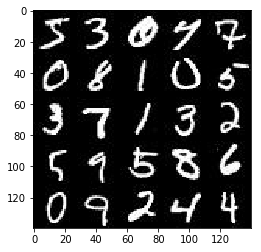

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

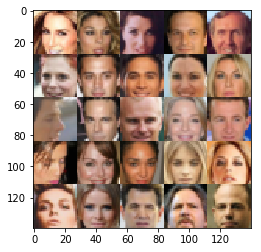

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)
    
    return inputs, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [63]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(x1 * alpha, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(x2 * alpha, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(x3 * alpha, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        # print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2 * alpha, x2)
        # print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3 * alpha, x3)
        # print(x3.shape)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.nn.tanh(logits)
        # print(out.shape)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [65]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [66]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in tf.trainable_variables() if var.name.find('generator')!=-1]
    d_vars = [var for var in tf.trainable_variables() if var.name.find('discriminator')!=-1]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [75]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every = 100
    print_every = 10
    # tf.reset_default_graph()
    
    print(data_shape)
    
    out_channel_dim = data_shape[3]
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, beta1=beta1, learning_rate=learning_rate)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps = steps + 1
                
                batch_images = batch_images * 2.0

                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print('Epoch: {}/{} Discrimator Loss: {:.4f} Generator Loss: {:.4f}'.format(epoch_i + 1, 
                                                                                       epoch_count, train_loss_d, 
                                                                                        train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    _ = show_generator_output(sess, 16, inputs_z, out_channel_dim, data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch: 1/2 Discrimator Loss: 0.7607 Generator Loss: 0.9056
Epoch: 1/2 Discrimator Loss: 1.3354 Generator Loss: 0.5715
Epoch: 1/2 Discrimator Loss: 1.4823 Generator Loss: 0.6293
Epoch: 1/2 Discrimator Loss: 1.6438 Generator Loss: 0.5364
Epoch: 1/2 Discrimator Loss: 1.2620 Generator Loss: 0.7931
Epoch: 1/2 Discrimator Loss: 1.4799 Generator Loss: 0.6122
Epoch: 1/2 Discrimator Loss: 1.4571 Generator Loss: 0.6915
Epoch: 1/2 Discrimator Loss: 1.3708 Generator Loss: 0.6697
Epoch: 1/2 Discrimator Loss: 1.1985 Generator Loss: 0.7976
Epoch: 1/2 Discrimator Loss: 1.3101 Generator Loss: 0.7032


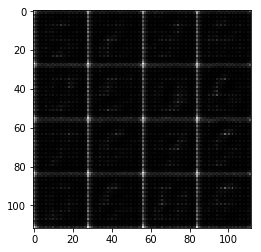

Epoch: 1/2 Discrimator Loss: 1.3727 Generator Loss: 0.6447
Epoch: 1/2 Discrimator Loss: 1.3204 Generator Loss: 0.6998
Epoch: 1/2 Discrimator Loss: 1.3933 Generator Loss: 0.6474
Epoch: 1/2 Discrimator Loss: 1.5072 Generator Loss: 0.5984
Epoch: 1/2 Discrimator Loss: 1.3491 Generator Loss: 0.5987
Epoch: 1/2 Discrimator Loss: 1.0811 Generator Loss: 0.8290
Epoch: 1/2 Discrimator Loss: 1.2955 Generator Loss: 0.7559
Epoch: 1/2 Discrimator Loss: 1.3151 Generator Loss: 0.7462
Epoch: 1/2 Discrimator Loss: 1.3887 Generator Loss: 0.6915
Epoch: 1/2 Discrimator Loss: 1.4260 Generator Loss: 0.6807


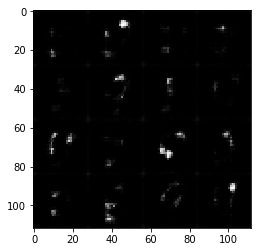

Epoch: 1/2 Discrimator Loss: 1.3922 Generator Loss: 0.6907
Epoch: 1/2 Discrimator Loss: 1.3628 Generator Loss: 0.6751
Epoch: 1/2 Discrimator Loss: 1.4236 Generator Loss: 0.6544
Epoch: 1/2 Discrimator Loss: 1.4222 Generator Loss: 0.6114
Epoch: 1/2 Discrimator Loss: 1.4238 Generator Loss: 0.6506
Epoch: 1/2 Discrimator Loss: 1.3614 Generator Loss: 0.7254
Epoch: 1/2 Discrimator Loss: 1.3978 Generator Loss: 0.6509
Epoch: 1/2 Discrimator Loss: 1.3222 Generator Loss: 0.6998
Epoch: 1/2 Discrimator Loss: 1.3168 Generator Loss: 0.6908
Epoch: 1/2 Discrimator Loss: 1.1969 Generator Loss: 0.8220


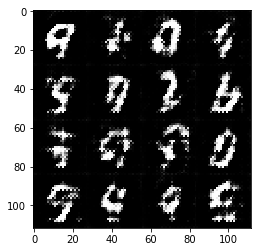

Epoch: 1/2 Discrimator Loss: 1.2360 Generator Loss: 0.8275
Epoch: 1/2 Discrimator Loss: 1.4642 Generator Loss: 0.6511
Epoch: 1/2 Discrimator Loss: 1.4179 Generator Loss: 0.6898
Epoch: 1/2 Discrimator Loss: 1.2698 Generator Loss: 0.7341
Epoch: 1/2 Discrimator Loss: 1.2496 Generator Loss: 0.7366
Epoch: 1/2 Discrimator Loss: 1.2599 Generator Loss: 0.7315
Epoch: 1/2 Discrimator Loss: 1.3581 Generator Loss: 0.7002
Epoch: 1/2 Discrimator Loss: 1.3603 Generator Loss: 0.7989
Epoch: 1/2 Discrimator Loss: 1.2785 Generator Loss: 0.6405
Epoch: 1/2 Discrimator Loss: 1.4504 Generator Loss: 0.7877


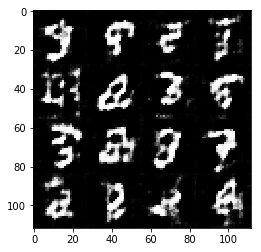

Epoch: 1/2 Discrimator Loss: 1.4745 Generator Loss: 0.4710
Epoch: 1/2 Discrimator Loss: 1.1683 Generator Loss: 0.7695
Epoch: 1/2 Discrimator Loss: 1.4125 Generator Loss: 0.7375
Epoch: 1/2 Discrimator Loss: 1.2933 Generator Loss: 0.7243
Epoch: 1/2 Discrimator Loss: 1.3880 Generator Loss: 0.7039
Epoch: 1/2 Discrimator Loss: 1.2958 Generator Loss: 0.6362
Epoch: 1/2 Discrimator Loss: 1.3315 Generator Loss: 0.5559
Epoch: 1/2 Discrimator Loss: 1.0600 Generator Loss: 0.7681
Epoch: 1/2 Discrimator Loss: 1.2948 Generator Loss: 0.7460
Epoch: 1/2 Discrimator Loss: 1.1736 Generator Loss: 0.7493


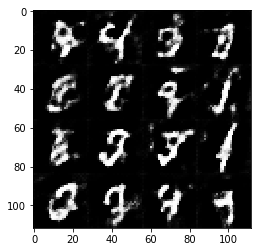

Epoch: 1/2 Discrimator Loss: 1.3908 Generator Loss: 0.6126
Epoch: 1/2 Discrimator Loss: 1.2564 Generator Loss: 0.6662
Epoch: 1/2 Discrimator Loss: 1.2281 Generator Loss: 1.2172
Epoch: 1/2 Discrimator Loss: 1.1799 Generator Loss: 0.8153
Epoch: 1/2 Discrimator Loss: 1.2465 Generator Loss: 0.6784
Epoch: 1/2 Discrimator Loss: 1.5276 Generator Loss: 0.7286
Epoch: 1/2 Discrimator Loss: 1.1395 Generator Loss: 0.7271
Epoch: 1/2 Discrimator Loss: 1.4204 Generator Loss: 0.7074
Epoch: 1/2 Discrimator Loss: 1.1513 Generator Loss: 0.7069
Epoch: 1/2 Discrimator Loss: 1.3910 Generator Loss: 0.6071


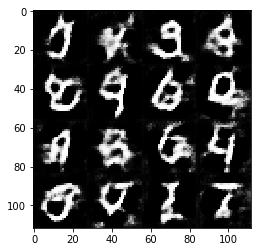

Epoch: 1/2 Discrimator Loss: 1.3840 Generator Loss: 0.6199
Epoch: 1/2 Discrimator Loss: 1.3843 Generator Loss: 0.6038
Epoch: 1/2 Discrimator Loss: 1.3811 Generator Loss: 0.5660
Epoch: 1/2 Discrimator Loss: 1.3864 Generator Loss: 0.7314
Epoch: 1/2 Discrimator Loss: 1.5162 Generator Loss: 0.5000
Epoch: 1/2 Discrimator Loss: 1.2308 Generator Loss: 0.7469
Epoch: 1/2 Discrimator Loss: 1.0538 Generator Loss: 0.7470
Epoch: 1/2 Discrimator Loss: 1.1269 Generator Loss: 0.8071
Epoch: 1/2 Discrimator Loss: 1.3798 Generator Loss: 0.6792
Epoch: 1/2 Discrimator Loss: 1.2420 Generator Loss: 0.7392


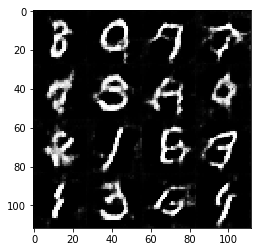

Epoch: 1/2 Discrimator Loss: 1.5419 Generator Loss: 0.5143
Epoch: 1/2 Discrimator Loss: 1.3210 Generator Loss: 0.6999
Epoch: 1/2 Discrimator Loss: 1.3529 Generator Loss: 0.5771
Epoch: 1/2 Discrimator Loss: 1.3855 Generator Loss: 0.6628
Epoch: 1/2 Discrimator Loss: 1.3336 Generator Loss: 0.9241
Epoch: 1/2 Discrimator Loss: 1.1386 Generator Loss: 0.7390
Epoch: 1/2 Discrimator Loss: 1.2818 Generator Loss: 0.6407
Epoch: 1/2 Discrimator Loss: 1.3475 Generator Loss: 0.7507
Epoch: 1/2 Discrimator Loss: 1.4973 Generator Loss: 0.5455
Epoch: 1/2 Discrimator Loss: 1.5570 Generator Loss: 0.5859


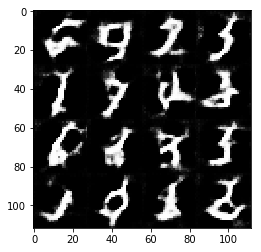

Epoch: 1/2 Discrimator Loss: 1.3018 Generator Loss: 0.6655
Epoch: 1/2 Discrimator Loss: 1.3662 Generator Loss: 0.6587
Epoch: 1/2 Discrimator Loss: 1.3201 Generator Loss: 0.7580
Epoch: 1/2 Discrimator Loss: 1.3562 Generator Loss: 0.9299
Epoch: 1/2 Discrimator Loss: 1.3810 Generator Loss: 0.7118
Epoch: 1/2 Discrimator Loss: 1.3777 Generator Loss: 0.6849
Epoch: 1/2 Discrimator Loss: 1.3779 Generator Loss: 0.6882
Epoch: 1/2 Discrimator Loss: 1.5541 Generator Loss: 0.4927
Epoch: 1/2 Discrimator Loss: 1.3385 Generator Loss: 0.6211
Epoch: 1/2 Discrimator Loss: 1.2159 Generator Loss: 0.9230


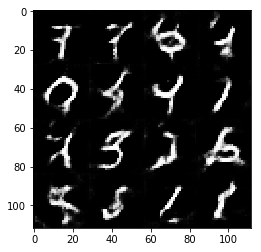

Epoch: 1/2 Discrimator Loss: 1.0339 Generator Loss: 0.8664
Epoch: 1/2 Discrimator Loss: 1.1698 Generator Loss: 0.8098
Epoch: 1/2 Discrimator Loss: 1.2848 Generator Loss: 0.7359
Epoch: 1/2 Discrimator Loss: 1.3468 Generator Loss: 0.5984
Epoch: 1/2 Discrimator Loss: 1.3342 Generator Loss: 0.8298
Epoch: 1/2 Discrimator Loss: 1.3763 Generator Loss: 0.7708
Epoch: 1/2 Discrimator Loss: 1.4063 Generator Loss: 0.6389
Epoch: 1/2 Discrimator Loss: 1.2711 Generator Loss: 0.7247
Epoch: 1/2 Discrimator Loss: 1.3109 Generator Loss: 0.6895
Epoch: 1/2 Discrimator Loss: 1.3041 Generator Loss: 0.7384


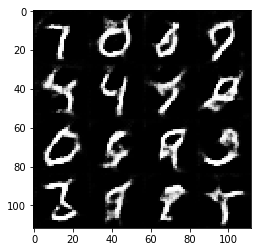

Epoch: 1/2 Discrimator Loss: 1.2314 Generator Loss: 0.7827
Epoch: 1/2 Discrimator Loss: 1.2969 Generator Loss: 0.7140
Epoch: 1/2 Discrimator Loss: 1.2330 Generator Loss: 0.7198
Epoch: 1/2 Discrimator Loss: 1.5608 Generator Loss: 0.5045
Epoch: 1/2 Discrimator Loss: 1.2359 Generator Loss: 0.7654
Epoch: 1/2 Discrimator Loss: 1.2454 Generator Loss: 0.7568
Epoch: 1/2 Discrimator Loss: 1.1627 Generator Loss: 0.8175
Epoch: 1/2 Discrimator Loss: 1.2261 Generator Loss: 0.7181
Epoch: 1/2 Discrimator Loss: 1.0939 Generator Loss: 0.9391
Epoch: 1/2 Discrimator Loss: 1.4410 Generator Loss: 0.5521


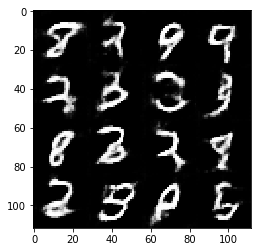

Epoch: 1/2 Discrimator Loss: 1.2914 Generator Loss: 0.7808
Epoch: 1/2 Discrimator Loss: 1.2190 Generator Loss: 0.7758
Epoch: 1/2 Discrimator Loss: 1.3725 Generator Loss: 0.6581
Epoch: 1/2 Discrimator Loss: 1.3710 Generator Loss: 0.6166
Epoch: 1/2 Discrimator Loss: 1.2428 Generator Loss: 0.7957
Epoch: 1/2 Discrimator Loss: 1.1770 Generator Loss: 0.7447
Epoch: 1/2 Discrimator Loss: 1.2662 Generator Loss: 0.7099
Epoch: 1/2 Discrimator Loss: 1.1968 Generator Loss: 0.7439
Epoch: 1/2 Discrimator Loss: 1.2410 Generator Loss: 0.8519
Epoch: 1/2 Discrimator Loss: 1.2946 Generator Loss: 0.6978


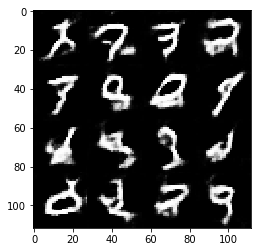

Epoch: 1/2 Discrimator Loss: 1.2871 Generator Loss: 0.7139
Epoch: 1/2 Discrimator Loss: 1.1541 Generator Loss: 0.7813
Epoch: 1/2 Discrimator Loss: 1.3962 Generator Loss: 0.6450
Epoch: 1/2 Discrimator Loss: 1.3774 Generator Loss: 0.5248
Epoch: 1/2 Discrimator Loss: 1.2154 Generator Loss: 0.8771
Epoch: 1/2 Discrimator Loss: 1.2096 Generator Loss: 0.8558
Epoch: 1/2 Discrimator Loss: 1.2445 Generator Loss: 0.6203
Epoch: 1/2 Discrimator Loss: 1.1777 Generator Loss: 0.8465
Epoch: 1/2 Discrimator Loss: 1.3990 Generator Loss: 0.6451
Epoch: 1/2 Discrimator Loss: 1.3357 Generator Loss: 0.6304


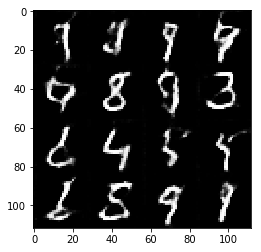

Epoch: 1/2 Discrimator Loss: 1.0868 Generator Loss: 0.8269
Epoch: 1/2 Discrimator Loss: 1.2581 Generator Loss: 0.7634
Epoch: 1/2 Discrimator Loss: 1.2611 Generator Loss: 0.8567
Epoch: 1/2 Discrimator Loss: 1.2231 Generator Loss: 0.7936
Epoch: 1/2 Discrimator Loss: 1.2883 Generator Loss: 0.5843
Epoch: 1/2 Discrimator Loss: 1.2405 Generator Loss: 0.8338
Epoch: 1/2 Discrimator Loss: 1.2304 Generator Loss: 0.7703
Epoch: 1/2 Discrimator Loss: 1.3759 Generator Loss: 0.7097
Epoch: 1/2 Discrimator Loss: 1.2535 Generator Loss: 0.7945
Epoch: 1/2 Discrimator Loss: 1.3530 Generator Loss: 0.6681


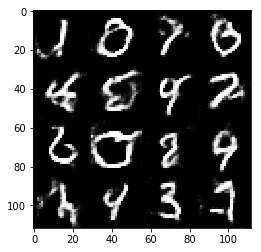

Epoch: 1/2 Discrimator Loss: 1.1894 Generator Loss: 0.7811
Epoch: 1/2 Discrimator Loss: 1.1321 Generator Loss: 0.8185
Epoch: 1/2 Discrimator Loss: 1.2053 Generator Loss: 0.7098
Epoch: 1/2 Discrimator Loss: 1.2469 Generator Loss: 0.7940
Epoch: 1/2 Discrimator Loss: 1.2130 Generator Loss: 0.7544
Epoch: 1/2 Discrimator Loss: 1.2318 Generator Loss: 0.7832
Epoch: 1/2 Discrimator Loss: 1.3199 Generator Loss: 0.6065
Epoch: 1/2 Discrimator Loss: 1.1864 Generator Loss: 0.6885
Epoch: 1/2 Discrimator Loss: 1.3391 Generator Loss: 0.6497
Epoch: 1/2 Discrimator Loss: 1.1832 Generator Loss: 0.7770


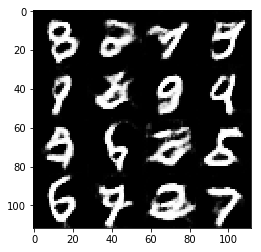

Epoch: 1/2 Discrimator Loss: 1.4802 Generator Loss: 0.5289
Epoch: 1/2 Discrimator Loss: 1.1577 Generator Loss: 1.0497
Epoch: 1/2 Discrimator Loss: 1.2144 Generator Loss: 0.7907
Epoch: 1/2 Discrimator Loss: 1.0432 Generator Loss: 0.9878
Epoch: 1/2 Discrimator Loss: 1.0798 Generator Loss: 0.8771
Epoch: 1/2 Discrimator Loss: 1.1308 Generator Loss: 0.8864
Epoch: 1/2 Discrimator Loss: 1.3101 Generator Loss: 0.6142
Epoch: 1/2 Discrimator Loss: 1.2148 Generator Loss: 0.8781
Epoch: 1/2 Discrimator Loss: 1.1455 Generator Loss: 0.8018
Epoch: 1/2 Discrimator Loss: 1.3061 Generator Loss: 0.8983


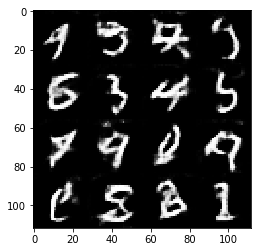

Epoch: 1/2 Discrimator Loss: 1.3108 Generator Loss: 0.7635
Epoch: 1/2 Discrimator Loss: 1.1133 Generator Loss: 0.8812
Epoch: 1/2 Discrimator Loss: 1.2301 Generator Loss: 0.6676
Epoch: 1/2 Discrimator Loss: 1.2149 Generator Loss: 0.6479
Epoch: 1/2 Discrimator Loss: 1.0252 Generator Loss: 0.8556
Epoch: 1/2 Discrimator Loss: 1.1929 Generator Loss: 0.7398
Epoch: 1/2 Discrimator Loss: 1.3120 Generator Loss: 0.6003
Epoch: 1/2 Discrimator Loss: 0.9262 Generator Loss: 1.1172
Epoch: 1/2 Discrimator Loss: 1.0834 Generator Loss: 0.8865
Epoch: 1/2 Discrimator Loss: 1.0038 Generator Loss: 0.8790


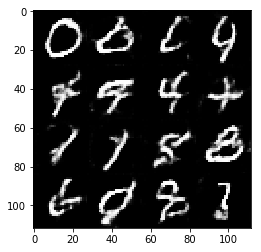

Epoch: 1/2 Discrimator Loss: 1.1223 Generator Loss: 0.8758
Epoch: 1/2 Discrimator Loss: 1.4313 Generator Loss: 0.5912
Epoch: 1/2 Discrimator Loss: 1.2701 Generator Loss: 0.7789
Epoch: 1/2 Discrimator Loss: 1.0358 Generator Loss: 0.9912
Epoch: 1/2 Discrimator Loss: 1.0628 Generator Loss: 1.0398
Epoch: 1/2 Discrimator Loss: 1.2152 Generator Loss: 0.7767
Epoch: 1/2 Discrimator Loss: 1.1289 Generator Loss: 0.9375
Epoch: 1/2 Discrimator Loss: 1.1322 Generator Loss: 0.8452
Epoch: 1/2 Discrimator Loss: 1.1287 Generator Loss: 0.7579
Epoch: 1/2 Discrimator Loss: 1.0860 Generator Loss: 1.0094


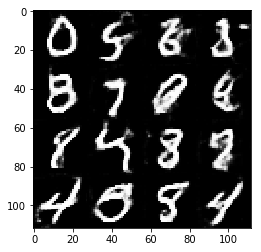

Epoch: 1/2 Discrimator Loss: 1.2437 Generator Loss: 0.7710
Epoch: 1/2 Discrimator Loss: 1.0573 Generator Loss: 0.8689
Epoch: 1/2 Discrimator Loss: 1.4129 Generator Loss: 0.7467
Epoch: 1/2 Discrimator Loss: 1.2156 Generator Loss: 0.6861
Epoch: 1/2 Discrimator Loss: 1.0829 Generator Loss: 0.9024
Epoch: 1/2 Discrimator Loss: 1.3752 Generator Loss: 0.5527
Epoch: 1/2 Discrimator Loss: 1.1503 Generator Loss: 0.8641
Epoch: 2/2 Discrimator Loss: 1.1381 Generator Loss: 0.8906
Epoch: 2/2 Discrimator Loss: 1.1975 Generator Loss: 0.8620
Epoch: 2/2 Discrimator Loss: 1.1655 Generator Loss: 0.7533


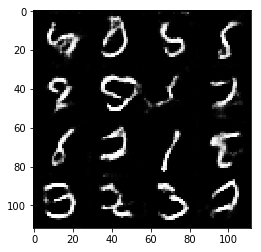

Epoch: 2/2 Discrimator Loss: 1.2760 Generator Loss: 0.6856
Epoch: 2/2 Discrimator Loss: 1.1866 Generator Loss: 0.7969
Epoch: 2/2 Discrimator Loss: 1.1986 Generator Loss: 0.7978
Epoch: 2/2 Discrimator Loss: 1.2474 Generator Loss: 0.8011
Epoch: 2/2 Discrimator Loss: 1.0940 Generator Loss: 0.8521
Epoch: 2/2 Discrimator Loss: 1.2668 Generator Loss: 0.7912
Epoch: 2/2 Discrimator Loss: 1.2967 Generator Loss: 0.7086
Epoch: 2/2 Discrimator Loss: 1.1266 Generator Loss: 0.9163
Epoch: 2/2 Discrimator Loss: 1.0082 Generator Loss: 1.1806
Epoch: 2/2 Discrimator Loss: 1.0132 Generator Loss: 0.8480


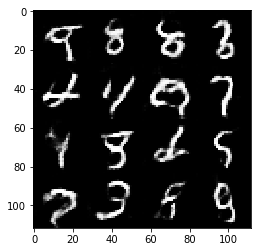

Epoch: 2/2 Discrimator Loss: 1.1204 Generator Loss: 0.8120
Epoch: 2/2 Discrimator Loss: 1.0680 Generator Loss: 0.9185
Epoch: 2/2 Discrimator Loss: 1.2153 Generator Loss: 0.7013
Epoch: 2/2 Discrimator Loss: 1.1214 Generator Loss: 0.8217
Epoch: 2/2 Discrimator Loss: 1.2119 Generator Loss: 0.7932
Epoch: 2/2 Discrimator Loss: 1.1376 Generator Loss: 0.8888
Epoch: 2/2 Discrimator Loss: 1.1855 Generator Loss: 0.7854
Epoch: 2/2 Discrimator Loss: 1.2752 Generator Loss: 0.7587
Epoch: 2/2 Discrimator Loss: 1.2148 Generator Loss: 0.7865
Epoch: 2/2 Discrimator Loss: 1.1642 Generator Loss: 0.7287


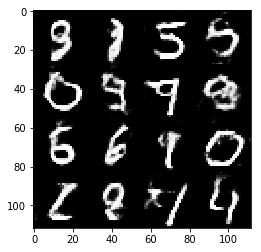

Epoch: 2/2 Discrimator Loss: 1.2581 Generator Loss: 0.5160
Epoch: 2/2 Discrimator Loss: 1.1954 Generator Loss: 0.7989
Epoch: 2/2 Discrimator Loss: 1.0091 Generator Loss: 0.8468
Epoch: 2/2 Discrimator Loss: 1.2881 Generator Loss: 0.7470
Epoch: 2/2 Discrimator Loss: 1.3921 Generator Loss: 0.5631
Epoch: 2/2 Discrimator Loss: 1.0237 Generator Loss: 0.9401
Epoch: 2/2 Discrimator Loss: 1.2370 Generator Loss: 0.6669
Epoch: 2/2 Discrimator Loss: 1.2274 Generator Loss: 0.9311
Epoch: 2/2 Discrimator Loss: 0.9879 Generator Loss: 0.9952
Epoch: 2/2 Discrimator Loss: 1.1509 Generator Loss: 0.7181


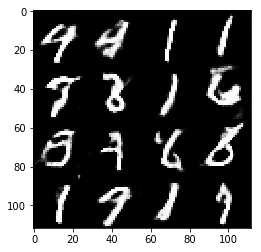

Epoch: 2/2 Discrimator Loss: 1.2411 Generator Loss: 1.0939
Epoch: 2/2 Discrimator Loss: 1.1205 Generator Loss: 1.4638
Epoch: 2/2 Discrimator Loss: 1.2293 Generator Loss: 0.8927
Epoch: 2/2 Discrimator Loss: 1.0809 Generator Loss: 0.9432
Epoch: 2/2 Discrimator Loss: 1.2571 Generator Loss: 0.8352
Epoch: 2/2 Discrimator Loss: 1.1237 Generator Loss: 0.7356
Epoch: 2/2 Discrimator Loss: 1.2120 Generator Loss: 0.9662
Epoch: 2/2 Discrimator Loss: 1.1853 Generator Loss: 0.6309
Epoch: 2/2 Discrimator Loss: 1.1068 Generator Loss: 0.7305
Epoch: 2/2 Discrimator Loss: 1.2974 Generator Loss: 0.6985


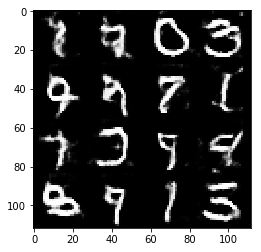

Epoch: 2/2 Discrimator Loss: 1.3660 Generator Loss: 0.8802
Epoch: 2/2 Discrimator Loss: 1.3071 Generator Loss: 0.6527
Epoch: 2/2 Discrimator Loss: 1.2251 Generator Loss: 0.9677
Epoch: 2/2 Discrimator Loss: 1.1163 Generator Loss: 0.8299
Epoch: 2/2 Discrimator Loss: 1.1163 Generator Loss: 0.8242
Epoch: 2/2 Discrimator Loss: 1.2678 Generator Loss: 0.7260
Epoch: 2/2 Discrimator Loss: 1.1748 Generator Loss: 0.7716
Epoch: 2/2 Discrimator Loss: 1.2291 Generator Loss: 0.7882
Epoch: 2/2 Discrimator Loss: 1.1451 Generator Loss: 0.7277
Epoch: 2/2 Discrimator Loss: 1.1961 Generator Loss: 0.6924


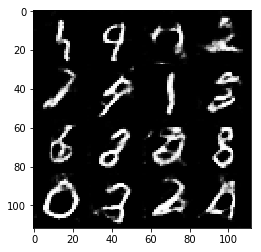

Epoch: 2/2 Discrimator Loss: 1.0451 Generator Loss: 1.1383
Epoch: 2/2 Discrimator Loss: 1.1847 Generator Loss: 0.9421
Epoch: 2/2 Discrimator Loss: 1.1917 Generator Loss: 0.7840
Epoch: 2/2 Discrimator Loss: 1.0697 Generator Loss: 0.9776
Epoch: 2/2 Discrimator Loss: 1.2176 Generator Loss: 0.7208
Epoch: 2/2 Discrimator Loss: 1.1477 Generator Loss: 0.9418
Epoch: 2/2 Discrimator Loss: 1.3782 Generator Loss: 0.7511
Epoch: 2/2 Discrimator Loss: 1.0678 Generator Loss: 0.9025
Epoch: 2/2 Discrimator Loss: 0.9735 Generator Loss: 1.0966
Epoch: 2/2 Discrimator Loss: 1.1009 Generator Loss: 0.9594


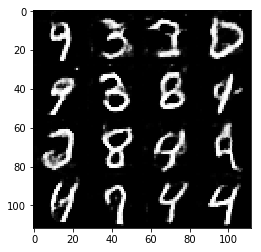

Epoch: 2/2 Discrimator Loss: 1.1994 Generator Loss: 0.9061
Epoch: 2/2 Discrimator Loss: 0.9437 Generator Loss: 0.9712
Epoch: 2/2 Discrimator Loss: 1.1365 Generator Loss: 0.8857
Epoch: 2/2 Discrimator Loss: 1.3152 Generator Loss: 0.5525
Epoch: 2/2 Discrimator Loss: 1.2551 Generator Loss: 0.5914
Epoch: 2/2 Discrimator Loss: 1.3147 Generator Loss: 0.7476
Epoch: 2/2 Discrimator Loss: 1.1911 Generator Loss: 0.9535
Epoch: 2/2 Discrimator Loss: 1.0394 Generator Loss: 0.9782
Epoch: 2/2 Discrimator Loss: 1.1729 Generator Loss: 0.8657
Epoch: 2/2 Discrimator Loss: 1.1658 Generator Loss: 0.9013


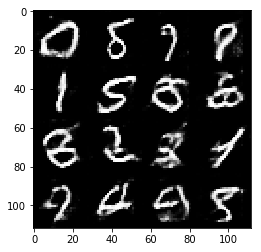

Epoch: 2/2 Discrimator Loss: 1.1503 Generator Loss: 0.9106
Epoch: 2/2 Discrimator Loss: 1.1525 Generator Loss: 0.7677
Epoch: 2/2 Discrimator Loss: 1.0903 Generator Loss: 0.8940
Epoch: 2/2 Discrimator Loss: 1.4337 Generator Loss: 0.6385
Epoch: 2/2 Discrimator Loss: 1.0863 Generator Loss: 0.7657
Epoch: 2/2 Discrimator Loss: 1.1379 Generator Loss: 0.8585
Epoch: 2/2 Discrimator Loss: 1.2859 Generator Loss: 0.6728
Epoch: 2/2 Discrimator Loss: 1.2743 Generator Loss: 1.2026
Epoch: 2/2 Discrimator Loss: 1.0746 Generator Loss: 0.9385
Epoch: 2/2 Discrimator Loss: 1.2133 Generator Loss: 0.8073


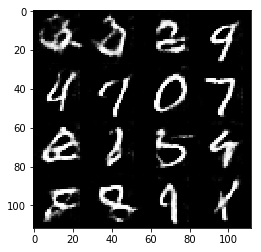

Epoch: 2/2 Discrimator Loss: 1.0668 Generator Loss: 1.2345
Epoch: 2/2 Discrimator Loss: 1.1974 Generator Loss: 0.7814
Epoch: 2/2 Discrimator Loss: 1.2513 Generator Loss: 0.7410
Epoch: 2/2 Discrimator Loss: 0.9464 Generator Loss: 0.9234
Epoch: 2/2 Discrimator Loss: 1.0393 Generator Loss: 0.9090
Epoch: 2/2 Discrimator Loss: 1.1801 Generator Loss: 0.7176
Epoch: 2/2 Discrimator Loss: 1.0097 Generator Loss: 1.1353
Epoch: 2/2 Discrimator Loss: 1.1724 Generator Loss: 0.9332
Epoch: 2/2 Discrimator Loss: 1.2203 Generator Loss: 0.9433
Epoch: 2/2 Discrimator Loss: 1.2156 Generator Loss: 0.6849


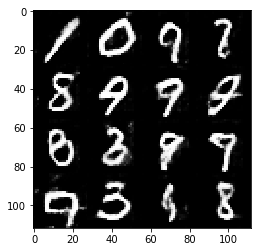

Epoch: 2/2 Discrimator Loss: 1.1903 Generator Loss: 0.7769
Epoch: 2/2 Discrimator Loss: 1.1262 Generator Loss: 0.9878
Epoch: 2/2 Discrimator Loss: 1.1565 Generator Loss: 0.8593
Epoch: 2/2 Discrimator Loss: 1.0374 Generator Loss: 0.7752
Epoch: 2/2 Discrimator Loss: 1.1474 Generator Loss: 0.8937
Epoch: 2/2 Discrimator Loss: 1.3426 Generator Loss: 0.6435
Epoch: 2/2 Discrimator Loss: 1.1335 Generator Loss: 0.8806
Epoch: 2/2 Discrimator Loss: 0.9842 Generator Loss: 1.0305
Epoch: 2/2 Discrimator Loss: 1.0699 Generator Loss: 0.9057
Epoch: 2/2 Discrimator Loss: 0.9536 Generator Loss: 1.0441


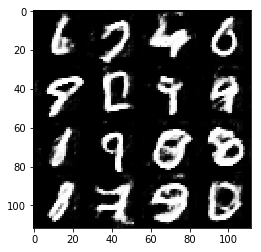

Epoch: 2/2 Discrimator Loss: 1.2080 Generator Loss: 0.7037
Epoch: 2/2 Discrimator Loss: 1.0644 Generator Loss: 0.9082
Epoch: 2/2 Discrimator Loss: 1.0148 Generator Loss: 1.1670
Epoch: 2/2 Discrimator Loss: 1.1772 Generator Loss: 0.6638
Epoch: 2/2 Discrimator Loss: 1.2643 Generator Loss: 0.6580
Epoch: 2/2 Discrimator Loss: 1.2032 Generator Loss: 0.6416
Epoch: 2/2 Discrimator Loss: 1.1175 Generator Loss: 0.8119
Epoch: 2/2 Discrimator Loss: 1.0040 Generator Loss: 0.8795
Epoch: 2/2 Discrimator Loss: 1.2403 Generator Loss: 0.8999
Epoch: 2/2 Discrimator Loss: 1.2174 Generator Loss: 0.9326


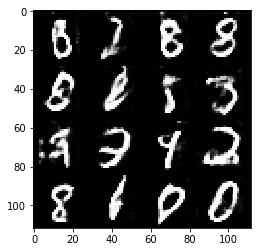

Epoch: 2/2 Discrimator Loss: 1.1475 Generator Loss: 0.7630
Epoch: 2/2 Discrimator Loss: 1.0559 Generator Loss: 1.0001
Epoch: 2/2 Discrimator Loss: 1.0931 Generator Loss: 0.7851
Epoch: 2/2 Discrimator Loss: 1.2110 Generator Loss: 0.7792
Epoch: 2/2 Discrimator Loss: 1.3085 Generator Loss: 0.6557
Epoch: 2/2 Discrimator Loss: 1.1217 Generator Loss: 0.9269
Epoch: 2/2 Discrimator Loss: 1.1253 Generator Loss: 0.7787
Epoch: 2/2 Discrimator Loss: 1.1173 Generator Loss: 0.9084
Epoch: 2/2 Discrimator Loss: 1.2574 Generator Loss: 0.6106
Epoch: 2/2 Discrimator Loss: 1.2208 Generator Loss: 0.9275


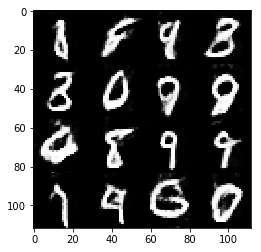

Epoch: 2/2 Discrimator Loss: 1.3875 Generator Loss: 0.6069
Epoch: 2/2 Discrimator Loss: 1.1151 Generator Loss: 0.7695
Epoch: 2/2 Discrimator Loss: 1.3634 Generator Loss: 0.6263
Epoch: 2/2 Discrimator Loss: 1.1927 Generator Loss: 0.8599
Epoch: 2/2 Discrimator Loss: 1.1218 Generator Loss: 0.7089
Epoch: 2/2 Discrimator Loss: 1.1971 Generator Loss: 0.8557
Epoch: 2/2 Discrimator Loss: 1.2030 Generator Loss: 0.6450
Epoch: 2/2 Discrimator Loss: 1.1955 Generator Loss: 1.0301
Epoch: 2/2 Discrimator Loss: 0.8586 Generator Loss: 1.0524
Epoch: 2/2 Discrimator Loss: 0.9128 Generator Loss: 1.0795


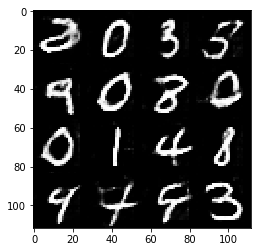

Epoch: 2/2 Discrimator Loss: 1.1057 Generator Loss: 1.0378
Epoch: 2/2 Discrimator Loss: 1.3424 Generator Loss: 0.8032
Epoch: 2/2 Discrimator Loss: 1.3054 Generator Loss: 0.7185
Epoch: 2/2 Discrimator Loss: 1.2184 Generator Loss: 0.8769
Epoch: 2/2 Discrimator Loss: 1.0458 Generator Loss: 0.9932
Epoch: 2/2 Discrimator Loss: 1.1054 Generator Loss: 1.0176
Epoch: 2/2 Discrimator Loss: 1.2227 Generator Loss: 0.7662
Epoch: 2/2 Discrimator Loss: 1.0972 Generator Loss: 0.8938
Epoch: 2/2 Discrimator Loss: 1.2227 Generator Loss: 0.7296
Epoch: 2/2 Discrimator Loss: 1.1575 Generator Loss: 0.7458


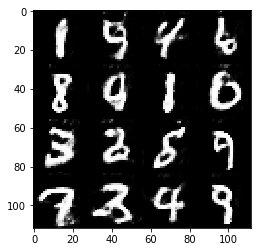

Epoch: 2/2 Discrimator Loss: 1.1108 Generator Loss: 1.0012
Epoch: 2/2 Discrimator Loss: 1.0788 Generator Loss: 0.7199
Epoch: 2/2 Discrimator Loss: 1.1445 Generator Loss: 0.7962
Epoch: 2/2 Discrimator Loss: 1.1834 Generator Loss: 0.9741
Epoch: 2/2 Discrimator Loss: 1.2108 Generator Loss: 0.8521
Epoch: 2/2 Discrimator Loss: 0.9558 Generator Loss: 1.0912
Epoch: 2/2 Discrimator Loss: 1.0682 Generator Loss: 0.8711
Epoch: 2/2 Discrimator Loss: 1.0477 Generator Loss: 0.9737
Epoch: 2/2 Discrimator Loss: 1.0669 Generator Loss: 0.8377
Epoch: 2/2 Discrimator Loss: 1.2127 Generator Loss: 0.7625


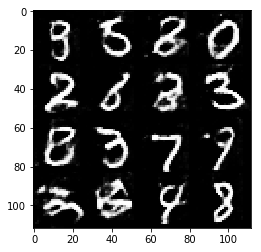

Epoch: 2/2 Discrimator Loss: 1.2592 Generator Loss: 0.6524
Epoch: 2/2 Discrimator Loss: 1.0961 Generator Loss: 0.7726
Epoch: 2/2 Discrimator Loss: 1.3145 Generator Loss: 0.6818
Epoch: 2/2 Discrimator Loss: 1.2263 Generator Loss: 0.8079
Epoch: 2/2 Discrimator Loss: 1.2105 Generator Loss: 0.7867
Epoch: 2/2 Discrimator Loss: 1.1587 Generator Loss: 0.6995
Epoch: 2/2 Discrimator Loss: 0.9554 Generator Loss: 1.1655
Epoch: 2/2 Discrimator Loss: 1.0858 Generator Loss: 0.8773
Epoch: 2/2 Discrimator Loss: 1.2693 Generator Loss: 0.9513
Epoch: 2/2 Discrimator Loss: 1.1647 Generator Loss: 0.8793


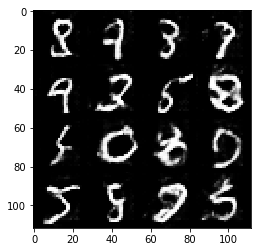

Epoch: 2/2 Discrimator Loss: 1.0793 Generator Loss: 1.0330
Epoch: 2/2 Discrimator Loss: 1.0529 Generator Loss: 0.9844
Epoch: 2/2 Discrimator Loss: 1.1122 Generator Loss: 0.7848
Epoch: 2/2 Discrimator Loss: 0.9964 Generator Loss: 0.9252
Epoch: 2/2 Discrimator Loss: 1.1414 Generator Loss: 0.8821
Epoch: 2/2 Discrimator Loss: 1.2420 Generator Loss: 0.7132
Epoch: 2/2 Discrimator Loss: 1.1915 Generator Loss: 0.6377
Epoch: 2/2 Discrimator Loss: 1.1455 Generator Loss: 0.9688
Epoch: 2/2 Discrimator Loss: 1.4301 Generator Loss: 0.4388
Epoch: 2/2 Discrimator Loss: 1.3041 Generator Loss: 0.8574


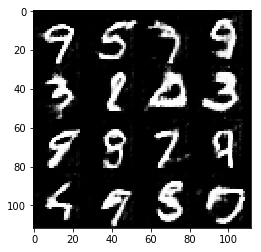

Epoch: 2/2 Discrimator Loss: 0.8296 Generator Loss: 1.2606
Epoch: 2/2 Discrimator Loss: 1.3385 Generator Loss: 0.6643
Epoch: 2/2 Discrimator Loss: 1.0960 Generator Loss: 1.0402
Epoch: 2/2 Discrimator Loss: 1.2695 Generator Loss: 0.8201
Epoch: 2/2 Discrimator Loss: 1.2225 Generator Loss: 0.7267
Epoch: 2/2 Discrimator Loss: 1.2074 Generator Loss: 0.8287
Epoch: 2/2 Discrimator Loss: 1.2845 Generator Loss: 0.6295
Epoch: 2/2 Discrimator Loss: 1.0868 Generator Loss: 0.7722
Epoch: 2/2 Discrimator Loss: 1.2781 Generator Loss: 0.7631
Epoch: 2/2 Discrimator Loss: 1.1184 Generator Loss: 0.9411


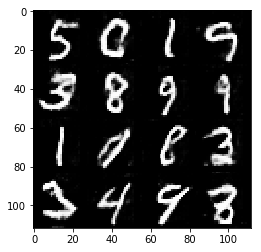

Epoch: 2/2 Discrimator Loss: 1.0371 Generator Loss: 1.1368
Epoch: 2/2 Discrimator Loss: 1.1111 Generator Loss: 0.7626
Epoch: 2/2 Discrimator Loss: 1.0585 Generator Loss: 0.9180
Epoch: 2/2 Discrimator Loss: 1.0951 Generator Loss: 1.0313
Epoch: 2/2 Discrimator Loss: 1.1870 Generator Loss: 0.7285


In [84]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch: 1/1 Discrimator Loss: 0.9338 Generator Loss: 1.1874
Epoch: 1/1 Discrimator Loss: 0.2493 Generator Loss: 2.7909
Epoch: 1/1 Discrimator Loss: 0.0953 Generator Loss: 3.0104
Epoch: 1/1 Discrimator Loss: 0.2634 Generator Loss: 1.8027
Epoch: 1/1 Discrimator Loss: 0.0913 Generator Loss: 5.4390
Epoch: 1/1 Discrimator Loss: 0.1057 Generator Loss: 3.6728
Epoch: 1/1 Discrimator Loss: 0.0586 Generator Loss: 4.8858
Epoch: 1/1 Discrimator Loss: 0.2161 Generator Loss: 3.5378
Epoch: 1/1 Discrimator Loss: 0.2392 Generator Loss: 5.1819
Epoch: 1/1 Discrimator Loss: 0.3663 Generator Loss: 2.5661


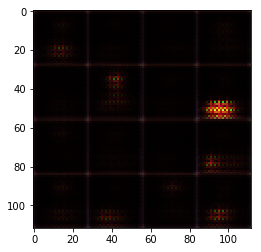

Epoch: 1/1 Discrimator Loss: 0.4381 Generator Loss: 2.7155
Epoch: 1/1 Discrimator Loss: 0.4461 Generator Loss: 3.3304
Epoch: 1/1 Discrimator Loss: 0.3274 Generator Loss: 2.9336
Epoch: 1/1 Discrimator Loss: 0.1839 Generator Loss: 3.6501
Epoch: 1/1 Discrimator Loss: 0.5665 Generator Loss: 1.8481
Epoch: 1/1 Discrimator Loss: 0.7427 Generator Loss: 1.0457
Epoch: 1/1 Discrimator Loss: 0.7457 Generator Loss: 1.7594
Epoch: 1/1 Discrimator Loss: 1.1191 Generator Loss: 1.5473
Epoch: 1/1 Discrimator Loss: 0.6314 Generator Loss: 1.7142
Epoch: 1/1 Discrimator Loss: 0.6914 Generator Loss: 1.4109


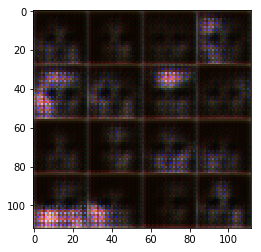

Epoch: 1/1 Discrimator Loss: 0.6059 Generator Loss: 1.4336
Epoch: 1/1 Discrimator Loss: 1.1628 Generator Loss: 0.9083
Epoch: 1/1 Discrimator Loss: 1.4204 Generator Loss: 0.9821
Epoch: 1/1 Discrimator Loss: 1.1804 Generator Loss: 1.2869
Epoch: 1/1 Discrimator Loss: 1.3569 Generator Loss: 0.6570
Epoch: 1/1 Discrimator Loss: 0.7947 Generator Loss: 1.0089
Epoch: 1/1 Discrimator Loss: 1.2194 Generator Loss: 1.1637
Epoch: 1/1 Discrimator Loss: 1.3131 Generator Loss: 0.6400
Epoch: 1/1 Discrimator Loss: 1.6314 Generator Loss: 0.6488
Epoch: 1/1 Discrimator Loss: 1.2007 Generator Loss: 0.8549


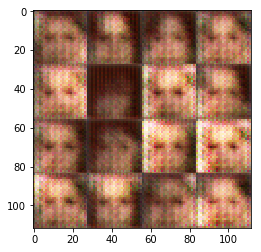

Epoch: 1/1 Discrimator Loss: 0.9315 Generator Loss: 0.8596
Epoch: 1/1 Discrimator Loss: 0.9929 Generator Loss: 0.8585
Epoch: 1/1 Discrimator Loss: 1.1252 Generator Loss: 0.8589
Epoch: 1/1 Discrimator Loss: 1.1304 Generator Loss: 0.8762
Epoch: 1/1 Discrimator Loss: 0.8561 Generator Loss: 0.8873
Epoch: 1/1 Discrimator Loss: 1.4164 Generator Loss: 0.6995
Epoch: 1/1 Discrimator Loss: 1.3881 Generator Loss: 0.7308
Epoch: 1/1 Discrimator Loss: 1.3247 Generator Loss: 0.8719
Epoch: 1/1 Discrimator Loss: 1.1426 Generator Loss: 1.2193
Epoch: 1/1 Discrimator Loss: 1.3738 Generator Loss: 0.6529


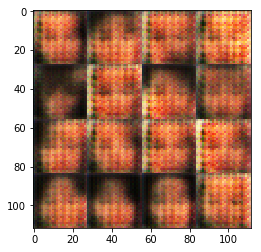

Epoch: 1/1 Discrimator Loss: 0.5706 Generator Loss: 1.3186
Epoch: 1/1 Discrimator Loss: 1.2634 Generator Loss: 1.1151
Epoch: 1/1 Discrimator Loss: 1.1163 Generator Loss: 1.0059
Epoch: 1/1 Discrimator Loss: 1.1673 Generator Loss: 1.1362
Epoch: 1/1 Discrimator Loss: 1.1873 Generator Loss: 0.9660
Epoch: 1/1 Discrimator Loss: 1.1084 Generator Loss: 0.9111
Epoch: 1/1 Discrimator Loss: 1.3941 Generator Loss: 0.8683
Epoch: 1/1 Discrimator Loss: 1.2161 Generator Loss: 0.8084
Epoch: 1/1 Discrimator Loss: 1.1999 Generator Loss: 0.7760
Epoch: 1/1 Discrimator Loss: 1.2678 Generator Loss: 0.7571


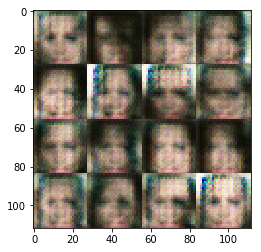

Epoch: 1/1 Discrimator Loss: 1.4187 Generator Loss: 0.7115
Epoch: 1/1 Discrimator Loss: 1.1183 Generator Loss: 0.8376
Epoch: 1/1 Discrimator Loss: 1.1770 Generator Loss: 0.8549
Epoch: 1/1 Discrimator Loss: 1.2730 Generator Loss: 0.7806
Epoch: 1/1 Discrimator Loss: 1.2601 Generator Loss: 0.7959
Epoch: 1/1 Discrimator Loss: 1.2074 Generator Loss: 0.7553
Epoch: 1/1 Discrimator Loss: 1.2378 Generator Loss: 0.7788
Epoch: 1/1 Discrimator Loss: 1.1218 Generator Loss: 0.8158
Epoch: 1/1 Discrimator Loss: 1.2752 Generator Loss: 0.7724
Epoch: 1/1 Discrimator Loss: 1.2320 Generator Loss: 0.7084


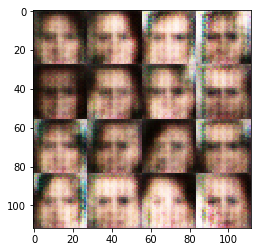

Epoch: 1/1 Discrimator Loss: 1.1358 Generator Loss: 0.8298
Epoch: 1/1 Discrimator Loss: 1.3342 Generator Loss: 0.8888
Epoch: 1/1 Discrimator Loss: 1.1440 Generator Loss: 0.8290
Epoch: 1/1 Discrimator Loss: 1.2107 Generator Loss: 0.7550
Epoch: 1/1 Discrimator Loss: 1.3006 Generator Loss: 0.7446
Epoch: 1/1 Discrimator Loss: 1.2254 Generator Loss: 0.7385
Epoch: 1/1 Discrimator Loss: 1.2707 Generator Loss: 0.7237
Epoch: 1/1 Discrimator Loss: 1.3359 Generator Loss: 0.7617
Epoch: 1/1 Discrimator Loss: 1.2507 Generator Loss: 0.7585
Epoch: 1/1 Discrimator Loss: 1.1385 Generator Loss: 0.8185


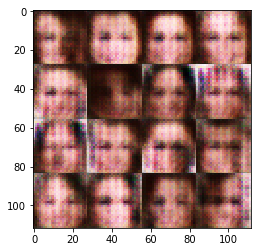

Epoch: 1/1 Discrimator Loss: 1.3118 Generator Loss: 0.7448
Epoch: 1/1 Discrimator Loss: 1.2104 Generator Loss: 0.7567
Epoch: 1/1 Discrimator Loss: 1.3982 Generator Loss: 0.7530
Epoch: 1/1 Discrimator Loss: 1.2478 Generator Loss: 0.8054
Epoch: 1/1 Discrimator Loss: 1.3623 Generator Loss: 0.7267
Epoch: 1/1 Discrimator Loss: 1.5539 Generator Loss: 0.6435
Epoch: 1/1 Discrimator Loss: 1.2574 Generator Loss: 0.8516
Epoch: 1/1 Discrimator Loss: 0.8412 Generator Loss: 1.0095
Epoch: 1/1 Discrimator Loss: 0.7958 Generator Loss: 1.2183
Epoch: 1/1 Discrimator Loss: 1.3207 Generator Loss: 0.8541


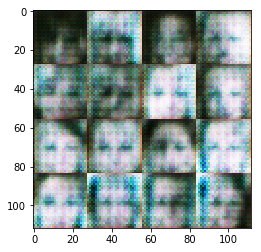

Epoch: 1/1 Discrimator Loss: 1.3923 Generator Loss: 0.7462
Epoch: 1/1 Discrimator Loss: 1.3679 Generator Loss: 0.7972
Epoch: 1/1 Discrimator Loss: 1.3540 Generator Loss: 0.7440
Epoch: 1/1 Discrimator Loss: 1.4039 Generator Loss: 0.6985
Epoch: 1/1 Discrimator Loss: 1.2100 Generator Loss: 0.7896
Epoch: 1/1 Discrimator Loss: 1.3779 Generator Loss: 0.7079
Epoch: 1/1 Discrimator Loss: 1.2672 Generator Loss: 0.7373
Epoch: 1/1 Discrimator Loss: 1.1455 Generator Loss: 0.7491
Epoch: 1/1 Discrimator Loss: 1.4211 Generator Loss: 0.6802
Epoch: 1/1 Discrimator Loss: 1.2280 Generator Loss: 0.7990


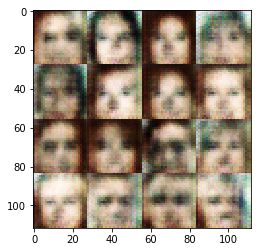

Epoch: 1/1 Discrimator Loss: 1.2251 Generator Loss: 0.7395
Epoch: 1/1 Discrimator Loss: 1.1585 Generator Loss: 0.8509
Epoch: 1/1 Discrimator Loss: 1.3043 Generator Loss: 0.8003
Epoch: 1/1 Discrimator Loss: 1.2560 Generator Loss: 0.9256
Epoch: 1/1 Discrimator Loss: 1.3953 Generator Loss: 0.6750
Epoch: 1/1 Discrimator Loss: 1.4809 Generator Loss: 1.1105
Epoch: 1/1 Discrimator Loss: 1.7661 Generator Loss: 0.6207
Epoch: 1/1 Discrimator Loss: 1.3730 Generator Loss: 0.8063
Epoch: 1/1 Discrimator Loss: 1.1662 Generator Loss: 0.7959
Epoch: 1/1 Discrimator Loss: 1.1407 Generator Loss: 0.7885


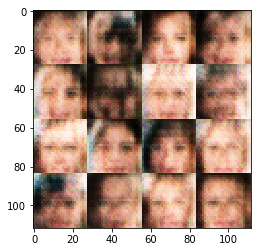

Epoch: 1/1 Discrimator Loss: 1.1048 Generator Loss: 0.7036
Epoch: 1/1 Discrimator Loss: 1.2228 Generator Loss: 0.8139
Epoch: 1/1 Discrimator Loss: 1.5055 Generator Loss: 0.5450
Epoch: 1/1 Discrimator Loss: 1.3409 Generator Loss: 0.8023
Epoch: 1/1 Discrimator Loss: 1.3972 Generator Loss: 0.6464
Epoch: 1/1 Discrimator Loss: 1.2674 Generator Loss: 1.0021
Epoch: 1/1 Discrimator Loss: 1.1874 Generator Loss: 0.7839
Epoch: 1/1 Discrimator Loss: 1.2797 Generator Loss: 0.5349
Epoch: 1/1 Discrimator Loss: 1.2584 Generator Loss: 0.8060
Epoch: 1/1 Discrimator Loss: 1.1763 Generator Loss: 0.8264


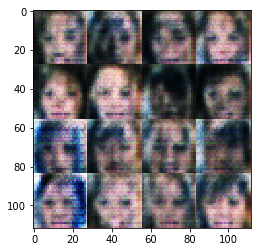

Epoch: 1/1 Discrimator Loss: 1.3009 Generator Loss: 1.1486
Epoch: 1/1 Discrimator Loss: 1.1799 Generator Loss: 0.8195
Epoch: 1/1 Discrimator Loss: 1.3084 Generator Loss: 0.9356
Epoch: 1/1 Discrimator Loss: 1.3817 Generator Loss: 0.6854
Epoch: 1/1 Discrimator Loss: 1.2059 Generator Loss: 0.9368
Epoch: 1/1 Discrimator Loss: 1.1619 Generator Loss: 0.7502
Epoch: 1/1 Discrimator Loss: 1.1927 Generator Loss: 0.9957
Epoch: 1/1 Discrimator Loss: 1.1884 Generator Loss: 0.7959
Epoch: 1/1 Discrimator Loss: 1.2351 Generator Loss: 0.9880
Epoch: 1/1 Discrimator Loss: 1.2695 Generator Loss: 0.8302


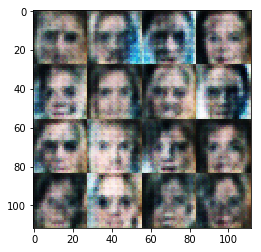

Epoch: 1/1 Discrimator Loss: 1.3172 Generator Loss: 1.3691
Epoch: 1/1 Discrimator Loss: 1.3950 Generator Loss: 0.6933
Epoch: 1/1 Discrimator Loss: 1.3255 Generator Loss: 0.9639
Epoch: 1/1 Discrimator Loss: 1.3454 Generator Loss: 0.6509
Epoch: 1/1 Discrimator Loss: 1.1763 Generator Loss: 0.8053
Epoch: 1/1 Discrimator Loss: 1.1694 Generator Loss: 0.6866
Epoch: 1/1 Discrimator Loss: 1.2239 Generator Loss: 0.8601
Epoch: 1/1 Discrimator Loss: 1.4066 Generator Loss: 0.7078
Epoch: 1/1 Discrimator Loss: 1.2642 Generator Loss: 1.0467
Epoch: 1/1 Discrimator Loss: 1.4143 Generator Loss: 0.6320


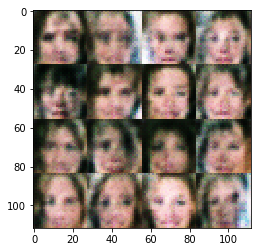

Epoch: 1/1 Discrimator Loss: 1.3165 Generator Loss: 1.3613
Epoch: 1/1 Discrimator Loss: 1.1518 Generator Loss: 0.7554
Epoch: 1/1 Discrimator Loss: 1.1268 Generator Loss: 0.8262
Epoch: 1/1 Discrimator Loss: 0.9980 Generator Loss: 1.1308
Epoch: 1/1 Discrimator Loss: 1.3389 Generator Loss: 0.5622
Epoch: 1/1 Discrimator Loss: 1.0369 Generator Loss: 1.0538
Epoch: 1/1 Discrimator Loss: 0.9457 Generator Loss: 0.9944
Epoch: 1/1 Discrimator Loss: 1.0021 Generator Loss: 0.9127
Epoch: 1/1 Discrimator Loss: 1.2421 Generator Loss: 0.5039
Epoch: 1/1 Discrimator Loss: 1.3001 Generator Loss: 1.1392


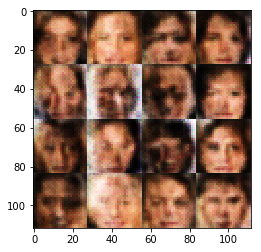

Epoch: 1/1 Discrimator Loss: 1.2140 Generator Loss: 0.7184
Epoch: 1/1 Discrimator Loss: 1.3330 Generator Loss: 0.7697
Epoch: 1/1 Discrimator Loss: 1.2514 Generator Loss: 0.7983
Epoch: 1/1 Discrimator Loss: 1.2761 Generator Loss: 0.7178
Epoch: 1/1 Discrimator Loss: 0.8991 Generator Loss: 1.0464
Epoch: 1/1 Discrimator Loss: 1.1581 Generator Loss: 0.8196
Epoch: 1/1 Discrimator Loss: 0.5424 Generator Loss: 1.0425
Epoch: 1/1 Discrimator Loss: 0.5711 Generator Loss: 3.2133
Epoch: 1/1 Discrimator Loss: 1.0162 Generator Loss: 0.9693
Epoch: 1/1 Discrimator Loss: 1.1471 Generator Loss: 1.1252


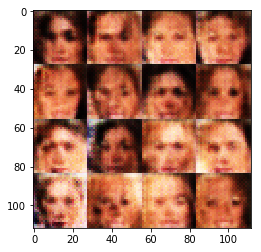

Epoch: 1/1 Discrimator Loss: 1.2066 Generator Loss: 0.7595
Epoch: 1/1 Discrimator Loss: 1.0964 Generator Loss: 1.2978
Epoch: 1/1 Discrimator Loss: 1.2582 Generator Loss: 0.7740
Epoch: 1/1 Discrimator Loss: 1.3564 Generator Loss: 0.8080
Epoch: 1/1 Discrimator Loss: 1.3951 Generator Loss: 0.6931
Epoch: 1/1 Discrimator Loss: 1.3387 Generator Loss: 0.7426
Epoch: 1/1 Discrimator Loss: 1.3146 Generator Loss: 0.7601
Epoch: 1/1 Discrimator Loss: 1.2933 Generator Loss: 0.8293
Epoch: 1/1 Discrimator Loss: 1.3122 Generator Loss: 0.7178
Epoch: 1/1 Discrimator Loss: 1.3371 Generator Loss: 0.7623


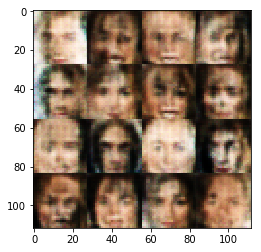

Epoch: 1/1 Discrimator Loss: 1.1857 Generator Loss: 0.7853
Epoch: 1/1 Discrimator Loss: 1.1967 Generator Loss: 0.8074
Epoch: 1/1 Discrimator Loss: 1.2549 Generator Loss: 0.7372
Epoch: 1/1 Discrimator Loss: 1.1716 Generator Loss: 0.8007
Epoch: 1/1 Discrimator Loss: 1.3770 Generator Loss: 0.8716
Epoch: 1/1 Discrimator Loss: 1.4048 Generator Loss: 1.2334
Epoch: 1/1 Discrimator Loss: 1.2565 Generator Loss: 0.8607
Epoch: 1/1 Discrimator Loss: 1.1752 Generator Loss: 0.7645
Epoch: 1/1 Discrimator Loss: 1.3901 Generator Loss: 0.5766
Epoch: 1/1 Discrimator Loss: 1.3057 Generator Loss: 1.1782


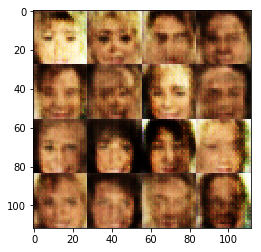

Epoch: 1/1 Discrimator Loss: 1.3348 Generator Loss: 0.7734
Epoch: 1/1 Discrimator Loss: 1.3402 Generator Loss: 1.0041
Epoch: 1/1 Discrimator Loss: 1.4407 Generator Loss: 0.7373
Epoch: 1/1 Discrimator Loss: 1.3218 Generator Loss: 0.6941
Epoch: 1/1 Discrimator Loss: 1.1964 Generator Loss: 1.0883
Epoch: 1/1 Discrimator Loss: 1.3670 Generator Loss: 0.6772
Epoch: 1/1 Discrimator Loss: 1.1763 Generator Loss: 0.8815
Epoch: 1/1 Discrimator Loss: 1.3625 Generator Loss: 0.6932
Epoch: 1/1 Discrimator Loss: 1.1398 Generator Loss: 0.8338
Epoch: 1/1 Discrimator Loss: 1.2290 Generator Loss: 0.7543


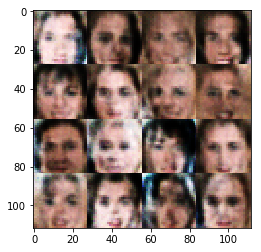

Epoch: 1/1 Discrimator Loss: 1.3099 Generator Loss: 0.8571
Epoch: 1/1 Discrimator Loss: 1.3003 Generator Loss: 0.6654
Epoch: 1/1 Discrimator Loss: 1.2378 Generator Loss: 0.6892
Epoch: 1/1 Discrimator Loss: 1.1413 Generator Loss: 0.7677
Epoch: 1/1 Discrimator Loss: 1.3744 Generator Loss: 0.7613
Epoch: 1/1 Discrimator Loss: 1.3723 Generator Loss: 0.7984
Epoch: 1/1 Discrimator Loss: 1.3400 Generator Loss: 0.7189
Epoch: 1/1 Discrimator Loss: 1.2744 Generator Loss: 0.6540
Epoch: 1/1 Discrimator Loss: 1.3477 Generator Loss: 0.7952
Epoch: 1/1 Discrimator Loss: 1.3296 Generator Loss: 0.7486


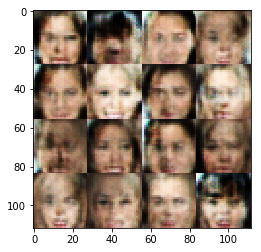

Epoch: 1/1 Discrimator Loss: 1.2563 Generator Loss: 0.7170
Epoch: 1/1 Discrimator Loss: 1.2539 Generator Loss: 0.7733
Epoch: 1/1 Discrimator Loss: 1.4807 Generator Loss: 0.7067
Epoch: 1/1 Discrimator Loss: 1.3849 Generator Loss: 0.9040
Epoch: 1/1 Discrimator Loss: 1.2731 Generator Loss: 0.7572
Epoch: 1/1 Discrimator Loss: 1.2217 Generator Loss: 0.7505
Epoch: 1/1 Discrimator Loss: 1.2962 Generator Loss: 0.8555
Epoch: 1/1 Discrimator Loss: 1.2981 Generator Loss: 0.6982
Epoch: 1/1 Discrimator Loss: 1.3216 Generator Loss: 0.7279
Epoch: 1/1 Discrimator Loss: 1.3146 Generator Loss: 0.7573


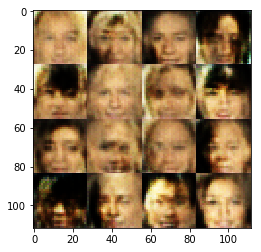

Epoch: 1/1 Discrimator Loss: 1.2667 Generator Loss: 0.7561
Epoch: 1/1 Discrimator Loss: 1.3002 Generator Loss: 0.7812
Epoch: 1/1 Discrimator Loss: 1.2613 Generator Loss: 0.8144
Epoch: 1/1 Discrimator Loss: 1.3272 Generator Loss: 0.7139
Epoch: 1/1 Discrimator Loss: 1.3481 Generator Loss: 0.7066
Epoch: 1/1 Discrimator Loss: 1.2783 Generator Loss: 0.7416
Epoch: 1/1 Discrimator Loss: 1.2796 Generator Loss: 0.7670
Epoch: 1/1 Discrimator Loss: 1.2196 Generator Loss: 0.8991
Epoch: 1/1 Discrimator Loss: 1.3825 Generator Loss: 0.7125
Epoch: 1/1 Discrimator Loss: 1.3875 Generator Loss: 0.7661


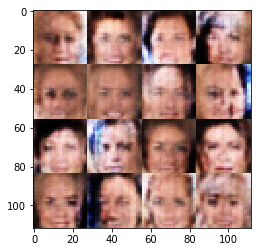

Epoch: 1/1 Discrimator Loss: 1.2316 Generator Loss: 0.7322
Epoch: 1/1 Discrimator Loss: 1.2586 Generator Loss: 0.7031
Epoch: 1/1 Discrimator Loss: 1.4078 Generator Loss: 0.8722
Epoch: 1/1 Discrimator Loss: 1.3148 Generator Loss: 0.6532
Epoch: 1/1 Discrimator Loss: 1.1263 Generator Loss: 0.8581
Epoch: 1/1 Discrimator Loss: 1.3046 Generator Loss: 0.9172
Epoch: 1/1 Discrimator Loss: 1.2594 Generator Loss: 0.7258
Epoch: 1/1 Discrimator Loss: 1.3725 Generator Loss: 0.6376
Epoch: 1/1 Discrimator Loss: 1.2018 Generator Loss: 0.9639
Epoch: 1/1 Discrimator Loss: 1.1527 Generator Loss: 0.6541


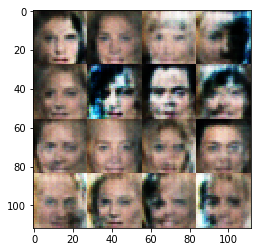

Epoch: 1/1 Discrimator Loss: 1.3576 Generator Loss: 0.8977
Epoch: 1/1 Discrimator Loss: 1.3654 Generator Loss: 0.6791
Epoch: 1/1 Discrimator Loss: 1.3494 Generator Loss: 0.8268
Epoch: 1/1 Discrimator Loss: 1.2927 Generator Loss: 0.8032
Epoch: 1/1 Discrimator Loss: 1.2859 Generator Loss: 0.7321
Epoch: 1/1 Discrimator Loss: 1.2140 Generator Loss: 0.8023
Epoch: 1/1 Discrimator Loss: 1.3423 Generator Loss: 0.6905
Epoch: 1/1 Discrimator Loss: 1.1905 Generator Loss: 0.7437
Epoch: 1/1 Discrimator Loss: 1.4129 Generator Loss: 0.7252
Epoch: 1/1 Discrimator Loss: 1.0649 Generator Loss: 0.8138


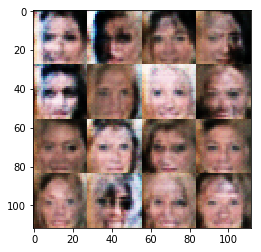

Epoch: 1/1 Discrimator Loss: 1.3353 Generator Loss: 0.7270
Epoch: 1/1 Discrimator Loss: 0.8969 Generator Loss: 1.2801
Epoch: 1/1 Discrimator Loss: 1.3272 Generator Loss: 0.5313
Epoch: 1/1 Discrimator Loss: 1.3915 Generator Loss: 0.6300
Epoch: 1/1 Discrimator Loss: 1.1335 Generator Loss: 1.1966
Epoch: 1/1 Discrimator Loss: 1.2385 Generator Loss: 1.0025
Epoch: 1/1 Discrimator Loss: 1.3989 Generator Loss: 0.7657
Epoch: 1/1 Discrimator Loss: 1.3572 Generator Loss: 0.6775
Epoch: 1/1 Discrimator Loss: 1.1968 Generator Loss: 1.0096
Epoch: 1/1 Discrimator Loss: 1.1875 Generator Loss: 0.8311


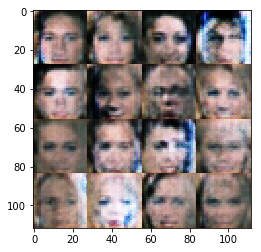

Epoch: 1/1 Discrimator Loss: 1.4589 Generator Loss: 0.9935
Epoch: 1/1 Discrimator Loss: 1.5933 Generator Loss: 0.7953
Epoch: 1/1 Discrimator Loss: 1.2520 Generator Loss: 0.8122
Epoch: 1/1 Discrimator Loss: 1.2455 Generator Loss: 0.9139
Epoch: 1/1 Discrimator Loss: 1.2872 Generator Loss: 0.6979
Epoch: 1/1 Discrimator Loss: 1.2581 Generator Loss: 0.8533
Epoch: 1/1 Discrimator Loss: 1.3257 Generator Loss: 0.7495
Epoch: 1/1 Discrimator Loss: 1.2904 Generator Loss: 0.7387
Epoch: 1/1 Discrimator Loss: 1.3019 Generator Loss: 0.7894
Epoch: 1/1 Discrimator Loss: 1.3370 Generator Loss: 0.8080


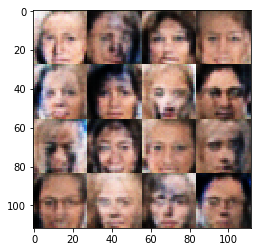

Epoch: 1/1 Discrimator Loss: 1.2669 Generator Loss: 0.7426
Epoch: 1/1 Discrimator Loss: 1.3733 Generator Loss: 0.7143
Epoch: 1/1 Discrimator Loss: 1.2180 Generator Loss: 0.8017
Epoch: 1/1 Discrimator Loss: 1.3381 Generator Loss: 0.7792
Epoch: 1/1 Discrimator Loss: 1.3603 Generator Loss: 0.6772
Epoch: 1/1 Discrimator Loss: 1.2837 Generator Loss: 0.6219
Epoch: 1/1 Discrimator Loss: 1.1069 Generator Loss: 0.9000
Epoch: 1/1 Discrimator Loss: 1.3878 Generator Loss: 0.7526
Epoch: 1/1 Discrimator Loss: 1.4631 Generator Loss: 0.9275
Epoch: 1/1 Discrimator Loss: 1.4660 Generator Loss: 0.7516


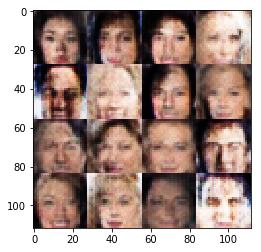

Epoch: 1/1 Discrimator Loss: 1.2166 Generator Loss: 0.6116
Epoch: 1/1 Discrimator Loss: 1.3461 Generator Loss: 0.8345
Epoch: 1/1 Discrimator Loss: 1.3940 Generator Loss: 0.6239
Epoch: 1/1 Discrimator Loss: 1.0595 Generator Loss: 0.8216
Epoch: 1/1 Discrimator Loss: 1.3100 Generator Loss: 0.9170
Epoch: 1/1 Discrimator Loss: 1.3807 Generator Loss: 0.7461
Epoch: 1/1 Discrimator Loss: 1.2666 Generator Loss: 0.9838
Epoch: 1/1 Discrimator Loss: 1.3002 Generator Loss: 0.7328
Epoch: 1/1 Discrimator Loss: 1.3256 Generator Loss: 0.7545
Epoch: 1/1 Discrimator Loss: 1.2734 Generator Loss: 0.7412


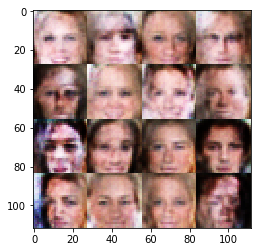

Epoch: 1/1 Discrimator Loss: 1.2989 Generator Loss: 0.7724
Epoch: 1/1 Discrimator Loss: 1.2430 Generator Loss: 0.7535
Epoch: 1/1 Discrimator Loss: 1.3923 Generator Loss: 0.7149
Epoch: 1/1 Discrimator Loss: 1.2917 Generator Loss: 0.7571
Epoch: 1/1 Discrimator Loss: 1.2112 Generator Loss: 0.7898
Epoch: 1/1 Discrimator Loss: 1.3005 Generator Loss: 0.6994
Epoch: 1/1 Discrimator Loss: 0.9956 Generator Loss: 0.8709
Epoch: 1/1 Discrimator Loss: 1.1236 Generator Loss: 0.7811
Epoch: 1/1 Discrimator Loss: 1.0169 Generator Loss: 1.0600
Epoch: 1/1 Discrimator Loss: 1.1235 Generator Loss: 1.2309


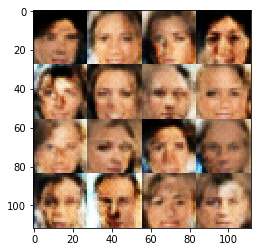

Epoch: 1/1 Discrimator Loss: 1.2754 Generator Loss: 1.0320
Epoch: 1/1 Discrimator Loss: 1.4828 Generator Loss: 0.8813
Epoch: 1/1 Discrimator Loss: 1.2675 Generator Loss: 0.7627
Epoch: 1/1 Discrimator Loss: 1.3098 Generator Loss: 0.7633
Epoch: 1/1 Discrimator Loss: 1.3312 Generator Loss: 0.7606
Epoch: 1/1 Discrimator Loss: 1.2799 Generator Loss: 0.8611
Epoch: 1/1 Discrimator Loss: 1.1943 Generator Loss: 0.8310
Epoch: 1/1 Discrimator Loss: 1.2533 Generator Loss: 0.7151
Epoch: 1/1 Discrimator Loss: 1.3135 Generator Loss: 0.8115
Epoch: 1/1 Discrimator Loss: 1.3865 Generator Loss: 0.6144


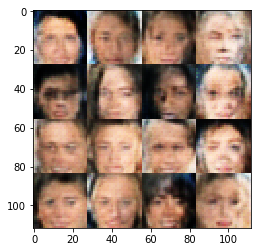

Epoch: 1/1 Discrimator Loss: 1.3325 Generator Loss: 0.8369
Epoch: 1/1 Discrimator Loss: 1.3527 Generator Loss: 0.6893
Epoch: 1/1 Discrimator Loss: 1.2960 Generator Loss: 0.7190
Epoch: 1/1 Discrimator Loss: 1.2225 Generator Loss: 0.8279
Epoch: 1/1 Discrimator Loss: 1.2562 Generator Loss: 0.7028
Epoch: 1/1 Discrimator Loss: 1.3859 Generator Loss: 0.8094
Epoch: 1/1 Discrimator Loss: 1.2494 Generator Loss: 0.7260
Epoch: 1/1 Discrimator Loss: 1.1619 Generator Loss: 0.7935
Epoch: 1/1 Discrimator Loss: 1.2365 Generator Loss: 0.7207
Epoch: 1/1 Discrimator Loss: 1.3264 Generator Loss: 0.7650


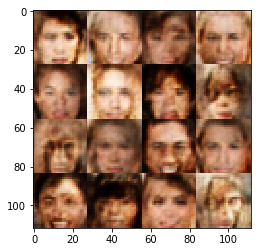

Epoch: 1/1 Discrimator Loss: 1.3124 Generator Loss: 0.6616
Epoch: 1/1 Discrimator Loss: 1.3345 Generator Loss: 0.6031
Epoch: 1/1 Discrimator Loss: 1.3827 Generator Loss: 0.7826
Epoch: 1/1 Discrimator Loss: 1.2613 Generator Loss: 0.7119
Epoch: 1/1 Discrimator Loss: 1.2038 Generator Loss: 0.7851
Epoch: 1/1 Discrimator Loss: 1.2922 Generator Loss: 0.7702
Epoch: 1/1 Discrimator Loss: 1.3429 Generator Loss: 0.8822
Epoch: 1/1 Discrimator Loss: 1.3494 Generator Loss: 0.6312
Epoch: 1/1 Discrimator Loss: 1.1968 Generator Loss: 0.7175
Epoch: 1/1 Discrimator Loss: 1.1806 Generator Loss: 0.7701


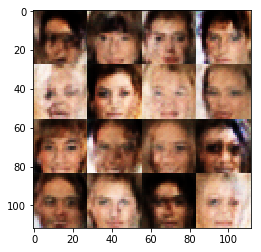

Epoch: 1/1 Discrimator Loss: 1.2321 Generator Loss: 0.7829
Epoch: 1/1 Discrimator Loss: 1.3906 Generator Loss: 0.9426
Epoch: 1/1 Discrimator Loss: 1.2408 Generator Loss: 0.6880
Epoch: 1/1 Discrimator Loss: 1.2821 Generator Loss: 0.8734
Epoch: 1/1 Discrimator Loss: 1.1644 Generator Loss: 0.7721
Epoch: 1/1 Discrimator Loss: 1.3149 Generator Loss: 0.6466
Epoch: 1/1 Discrimator Loss: 1.2102 Generator Loss: 0.9001
Epoch: 1/1 Discrimator Loss: 1.2964 Generator Loss: 0.7183
Epoch: 1/1 Discrimator Loss: 1.3253 Generator Loss: 0.9677
Epoch: 1/1 Discrimator Loss: 1.3466 Generator Loss: 0.6931


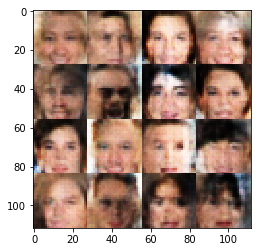

Epoch: 1/1 Discrimator Loss: 1.3094 Generator Loss: 0.7940
Epoch: 1/1 Discrimator Loss: 1.3205 Generator Loss: 0.8018
Epoch: 1/1 Discrimator Loss: 1.1830 Generator Loss: 0.7206
Epoch: 1/1 Discrimator Loss: 1.3310 Generator Loss: 0.7605
Epoch: 1/1 Discrimator Loss: 1.1006 Generator Loss: 0.8621
Epoch: 1/1 Discrimator Loss: 1.2601 Generator Loss: 0.7156
Epoch: 1/1 Discrimator Loss: 1.4191 Generator Loss: 0.7861
Epoch: 1/1 Discrimator Loss: 1.2374 Generator Loss: 0.7715
Epoch: 1/1 Discrimator Loss: 1.2456 Generator Loss: 0.8376
Epoch: 1/1 Discrimator Loss: 0.9913 Generator Loss: 0.7955


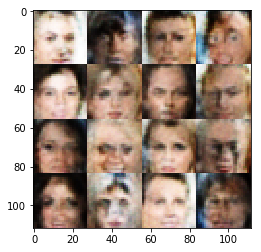

Epoch: 1/1 Discrimator Loss: 1.2728 Generator Loss: 0.8128
Epoch: 1/1 Discrimator Loss: 1.2957 Generator Loss: 0.7380
Epoch: 1/1 Discrimator Loss: 1.3080 Generator Loss: 0.8025
Epoch: 1/1 Discrimator Loss: 1.2362 Generator Loss: 0.7277
Epoch: 1/1 Discrimator Loss: 1.0363 Generator Loss: 0.9723
Epoch: 1/1 Discrimator Loss: 1.2641 Generator Loss: 0.6541
Epoch: 1/1 Discrimator Loss: 1.2033 Generator Loss: 0.9341
Epoch: 1/1 Discrimator Loss: 1.2987 Generator Loss: 0.7227
Epoch: 1/1 Discrimator Loss: 1.3080 Generator Loss: 0.8598
Epoch: 1/1 Discrimator Loss: 1.3565 Generator Loss: 0.7333


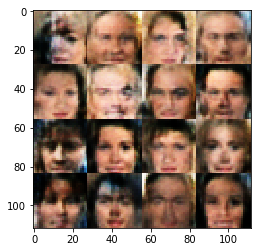

Epoch: 1/1 Discrimator Loss: 1.2509 Generator Loss: 0.8930
Epoch: 1/1 Discrimator Loss: 1.0382 Generator Loss: 0.7200
Epoch: 1/1 Discrimator Loss: 1.2523 Generator Loss: 0.7215
Epoch: 1/1 Discrimator Loss: 1.1476 Generator Loss: 0.7993
Epoch: 1/1 Discrimator Loss: 0.8455 Generator Loss: 1.1350
Epoch: 1/1 Discrimator Loss: 1.4949 Generator Loss: 1.0056
Epoch: 1/1 Discrimator Loss: 1.3158 Generator Loss: 0.7514
Epoch: 1/1 Discrimator Loss: 1.3415 Generator Loss: 0.7939
Epoch: 1/1 Discrimator Loss: 1.2717 Generator Loss: 0.7378
Epoch: 1/1 Discrimator Loss: 1.2886 Generator Loss: 0.7411


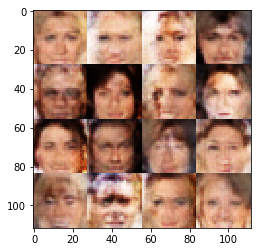

Epoch: 1/1 Discrimator Loss: 1.0519 Generator Loss: 0.7362
Epoch: 1/1 Discrimator Loss: 1.2398 Generator Loss: 0.8689
Epoch: 1/1 Discrimator Loss: 1.3282 Generator Loss: 0.8017
Epoch: 1/1 Discrimator Loss: 1.1731 Generator Loss: 0.7777
Epoch: 1/1 Discrimator Loss: 1.3838 Generator Loss: 0.8740
Epoch: 1/1 Discrimator Loss: 1.0883 Generator Loss: 0.7726
Epoch: 1/1 Discrimator Loss: 1.2000 Generator Loss: 0.8153
Epoch: 1/1 Discrimator Loss: 1.3111 Generator Loss: 0.6505
Epoch: 1/1 Discrimator Loss: 1.2818 Generator Loss: 0.5583
Epoch: 1/1 Discrimator Loss: 1.2414 Generator Loss: 0.8295


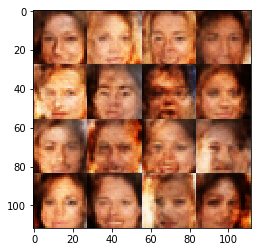

Epoch: 1/1 Discrimator Loss: 1.3216 Generator Loss: 0.8258
Epoch: 1/1 Discrimator Loss: 1.2519 Generator Loss: 0.9064
Epoch: 1/1 Discrimator Loss: 1.2569 Generator Loss: 0.8514
Epoch: 1/1 Discrimator Loss: 1.3330 Generator Loss: 0.6754
Epoch: 1/1 Discrimator Loss: 1.2656 Generator Loss: 0.8417
Epoch: 1/1 Discrimator Loss: 1.2301 Generator Loss: 0.7448
Epoch: 1/1 Discrimator Loss: 1.2276 Generator Loss: 0.7671
Epoch: 1/1 Discrimator Loss: 1.1053 Generator Loss: 0.9030
Epoch: 1/1 Discrimator Loss: 1.1516 Generator Loss: 0.8200
Epoch: 1/1 Discrimator Loss: 1.0632 Generator Loss: 0.9234


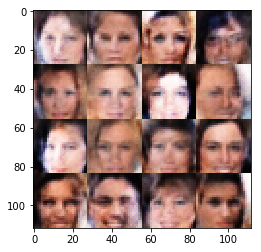

Epoch: 1/1 Discrimator Loss: 1.2908 Generator Loss: 0.7214
Epoch: 1/1 Discrimator Loss: 1.3677 Generator Loss: 0.6017
Epoch: 1/1 Discrimator Loss: 1.3233 Generator Loss: 0.5286
Epoch: 1/1 Discrimator Loss: 0.9897 Generator Loss: 1.1017
Epoch: 1/1 Discrimator Loss: 0.9874 Generator Loss: 0.8503
Epoch: 1/1 Discrimator Loss: 1.2679 Generator Loss: 1.2029
Epoch: 1/1 Discrimator Loss: 1.3071 Generator Loss: 0.9666
Epoch: 1/1 Discrimator Loss: 1.1883 Generator Loss: 1.0397
Epoch: 1/1 Discrimator Loss: 1.1646 Generator Loss: 0.8869
Epoch: 1/1 Discrimator Loss: 1.3239 Generator Loss: 0.7890


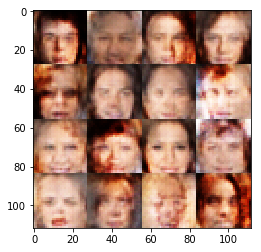

Epoch: 1/1 Discrimator Loss: 1.3325 Generator Loss: 0.7838
Epoch: 1/1 Discrimator Loss: 1.1277 Generator Loss: 0.7741
Epoch: 1/1 Discrimator Loss: 1.3189 Generator Loss: 0.8672
Epoch: 1/1 Discrimator Loss: 1.3644 Generator Loss: 0.7681
Epoch: 1/1 Discrimator Loss: 1.3152 Generator Loss: 0.7836
Epoch: 1/1 Discrimator Loss: 1.2818 Generator Loss: 0.7535
Epoch: 1/1 Discrimator Loss: 1.2987 Generator Loss: 0.6911
Epoch: 1/1 Discrimator Loss: 1.2754 Generator Loss: 0.7718
Epoch: 1/1 Discrimator Loss: 1.1598 Generator Loss: 0.6881
Epoch: 1/1 Discrimator Loss: 1.1162 Generator Loss: 0.9270


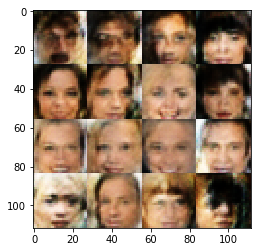

Epoch: 1/1 Discrimator Loss: 1.2897 Generator Loss: 0.8411
Epoch: 1/1 Discrimator Loss: 1.2606 Generator Loss: 0.7962
Epoch: 1/1 Discrimator Loss: 1.1372 Generator Loss: 0.8477
Epoch: 1/1 Discrimator Loss: 1.2058 Generator Loss: 0.6947
Epoch: 1/1 Discrimator Loss: 1.3294 Generator Loss: 0.7665
Epoch: 1/1 Discrimator Loss: 1.3384 Generator Loss: 0.8398
Epoch: 1/1 Discrimator Loss: 1.3231 Generator Loss: 0.8226
Epoch: 1/1 Discrimator Loss: 1.3105 Generator Loss: 0.8077
Epoch: 1/1 Discrimator Loss: 1.2477 Generator Loss: 0.7733
Epoch: 1/1 Discrimator Loss: 1.2553 Generator Loss: 0.8348


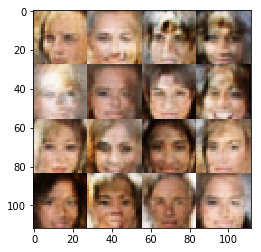

Epoch: 1/1 Discrimator Loss: 1.2685 Generator Loss: 0.7942
Epoch: 1/1 Discrimator Loss: 1.1306 Generator Loss: 0.7887
Epoch: 1/1 Discrimator Loss: 1.2573 Generator Loss: 0.9317
Epoch: 1/1 Discrimator Loss: 1.2567 Generator Loss: 0.8027
Epoch: 1/1 Discrimator Loss: 1.3357 Generator Loss: 0.8474
Epoch: 1/1 Discrimator Loss: 1.2352 Generator Loss: 0.7744
Epoch: 1/1 Discrimator Loss: 1.3632 Generator Loss: 0.7028
Epoch: 1/1 Discrimator Loss: 1.0539 Generator Loss: 0.8301
Epoch: 1/1 Discrimator Loss: 1.2098 Generator Loss: 0.7335
Epoch: 1/1 Discrimator Loss: 1.2219 Generator Loss: 0.8497


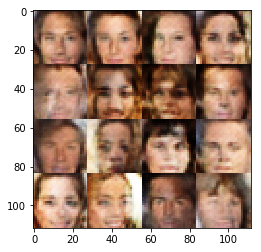

Epoch: 1/1 Discrimator Loss: 1.1810 Generator Loss: 0.7833
Epoch: 1/1 Discrimator Loss: 1.2941 Generator Loss: 0.6906
Epoch: 1/1 Discrimator Loss: 1.3915 Generator Loss: 0.7766
Epoch: 1/1 Discrimator Loss: 1.2609 Generator Loss: 0.7342
Epoch: 1/1 Discrimator Loss: 1.0475 Generator Loss: 0.9605
Epoch: 1/1 Discrimator Loss: 1.2361 Generator Loss: 0.7009
Epoch: 1/1 Discrimator Loss: 1.2561 Generator Loss: 0.8594
Epoch: 1/1 Discrimator Loss: 1.3035 Generator Loss: 0.6757
Epoch: 1/1 Discrimator Loss: 1.2163 Generator Loss: 0.8426
Epoch: 1/1 Discrimator Loss: 1.1738 Generator Loss: 0.8590


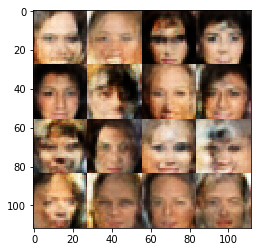

Epoch: 1/1 Discrimator Loss: 1.2454 Generator Loss: 0.7396
Epoch: 1/1 Discrimator Loss: 1.2314 Generator Loss: 0.9786
Epoch: 1/1 Discrimator Loss: 1.2600 Generator Loss: 0.8297
Epoch: 1/1 Discrimator Loss: 1.2497 Generator Loss: 0.7323
Epoch: 1/1 Discrimator Loss: 1.2414 Generator Loss: 0.7891
Epoch: 1/1 Discrimator Loss: 1.0207 Generator Loss: 0.8451
Epoch: 1/1 Discrimator Loss: 1.2633 Generator Loss: 0.7851
Epoch: 1/1 Discrimator Loss: 1.2159 Generator Loss: 0.6950
Epoch: 1/1 Discrimator Loss: 1.3333 Generator Loss: 0.8216
Epoch: 1/1 Discrimator Loss: 1.3750 Generator Loss: 0.7422


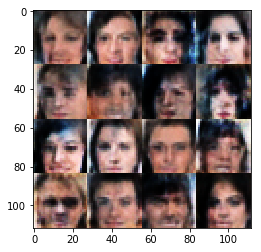

Epoch: 1/1 Discrimator Loss: 1.1140 Generator Loss: 0.8654
Epoch: 1/1 Discrimator Loss: 1.2243 Generator Loss: 0.7210
Epoch: 1/1 Discrimator Loss: 1.1411 Generator Loss: 0.8203
Epoch: 1/1 Discrimator Loss: 1.3098 Generator Loss: 0.7680
Epoch: 1/1 Discrimator Loss: 1.2629 Generator Loss: 0.8022
Epoch: 1/1 Discrimator Loss: 1.2601 Generator Loss: 0.9916
Epoch: 1/1 Discrimator Loss: 1.2988 Generator Loss: 0.7051
Epoch: 1/1 Discrimator Loss: 1.1871 Generator Loss: 0.9000
Epoch: 1/1 Discrimator Loss: 1.2744 Generator Loss: 0.7400
Epoch: 1/1 Discrimator Loss: 1.2842 Generator Loss: 0.8551


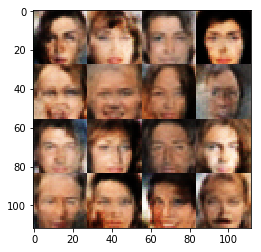

Epoch: 1/1 Discrimator Loss: 1.1390 Generator Loss: 0.8482
Epoch: 1/1 Discrimator Loss: 1.3136 Generator Loss: 0.7148
Epoch: 1/1 Discrimator Loss: 1.1072 Generator Loss: 0.8183
Epoch: 1/1 Discrimator Loss: 1.2605 Generator Loss: 0.7763
Epoch: 1/1 Discrimator Loss: 1.2469 Generator Loss: 1.0260
Epoch: 1/1 Discrimator Loss: 1.3216 Generator Loss: 0.9145
Epoch: 1/1 Discrimator Loss: 1.2438 Generator Loss: 1.0636
Epoch: 1/1 Discrimator Loss: 1.2135 Generator Loss: 0.8608
Epoch: 1/1 Discrimator Loss: 1.3987 Generator Loss: 0.6411
Epoch: 1/1 Discrimator Loss: 1.2737 Generator Loss: 0.9805


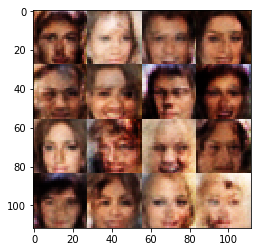

Epoch: 1/1 Discrimator Loss: 1.1351 Generator Loss: 0.7945
Epoch: 1/1 Discrimator Loss: 1.1970 Generator Loss: 0.8826
Epoch: 1/1 Discrimator Loss: 1.1993 Generator Loss: 0.8672
Epoch: 1/1 Discrimator Loss: 1.1589 Generator Loss: 0.7628
Epoch: 1/1 Discrimator Loss: 1.1494 Generator Loss: 0.9076
Epoch: 1/1 Discrimator Loss: 1.3598 Generator Loss: 0.7745
Epoch: 1/1 Discrimator Loss: 1.3019 Generator Loss: 0.8858
Epoch: 1/1 Discrimator Loss: 1.3134 Generator Loss: 0.6968
Epoch: 1/1 Discrimator Loss: 1.1159 Generator Loss: 0.8698
Epoch: 1/1 Discrimator Loss: 1.2176 Generator Loss: 0.8100


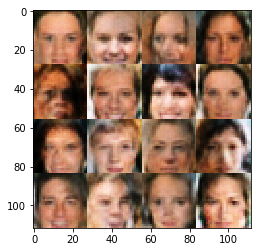

Epoch: 1/1 Discrimator Loss: 1.1230 Generator Loss: 0.7943
Epoch: 1/1 Discrimator Loss: 1.3544 Generator Loss: 0.9189
Epoch: 1/1 Discrimator Loss: 1.2214 Generator Loss: 0.9419
Epoch: 1/1 Discrimator Loss: 1.4115 Generator Loss: 0.8280
Epoch: 1/1 Discrimator Loss: 1.2838 Generator Loss: 0.6827
Epoch: 1/1 Discrimator Loss: 1.1934 Generator Loss: 0.6813
Epoch: 1/1 Discrimator Loss: 1.1760 Generator Loss: 0.8720
Epoch: 1/1 Discrimator Loss: 1.2316 Generator Loss: 0.8584
Epoch: 1/1 Discrimator Loss: 1.3063 Generator Loss: 0.7193
Epoch: 1/1 Discrimator Loss: 1.0922 Generator Loss: 0.7699


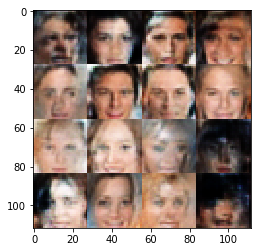

Epoch: 1/1 Discrimator Loss: 1.1626 Generator Loss: 1.0516
Epoch: 1/1 Discrimator Loss: 1.0242 Generator Loss: 0.8179
Epoch: 1/1 Discrimator Loss: 1.0363 Generator Loss: 0.8791
Epoch: 1/1 Discrimator Loss: 1.0750 Generator Loss: 0.7536
Epoch: 1/1 Discrimator Loss: 0.8525 Generator Loss: 1.3988
Epoch: 1/1 Discrimator Loss: 1.2469 Generator Loss: 0.6196
Epoch: 1/1 Discrimator Loss: 1.2263 Generator Loss: 0.6634
Epoch: 1/1 Discrimator Loss: 1.1974 Generator Loss: 0.7470
Epoch: 1/1 Discrimator Loss: 1.0897 Generator Loss: 1.0428
Epoch: 1/1 Discrimator Loss: 1.1108 Generator Loss: 1.0482


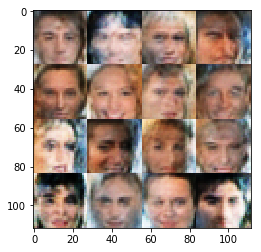

Epoch: 1/1 Discrimator Loss: 1.1923 Generator Loss: 0.8732
Epoch: 1/1 Discrimator Loss: 1.4420 Generator Loss: 0.6719
Epoch: 1/1 Discrimator Loss: 1.1629 Generator Loss: 0.8887
Epoch: 1/1 Discrimator Loss: 1.1983 Generator Loss: 0.8178
Epoch: 1/1 Discrimator Loss: 1.4143 Generator Loss: 0.9570
Epoch: 1/1 Discrimator Loss: 1.3533 Generator Loss: 0.7770
Epoch: 1/1 Discrimator Loss: 1.1857 Generator Loss: 0.8364
Epoch: 1/1 Discrimator Loss: 1.1335 Generator Loss: 0.8475
Epoch: 1/1 Discrimator Loss: 1.1857 Generator Loss: 0.8110
Epoch: 1/1 Discrimator Loss: 1.3269 Generator Loss: 0.7916


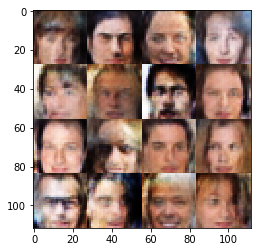

Epoch: 1/1 Discrimator Loss: 1.3166 Generator Loss: 0.7911
Epoch: 1/1 Discrimator Loss: 1.3360 Generator Loss: 0.8434
Epoch: 1/1 Discrimator Loss: 1.2561 Generator Loss: 0.7584
Epoch: 1/1 Discrimator Loss: 1.1547 Generator Loss: 0.7925
Epoch: 1/1 Discrimator Loss: 1.1532 Generator Loss: 0.8504
Epoch: 1/1 Discrimator Loss: 1.4083 Generator Loss: 0.7250
Epoch: 1/1 Discrimator Loss: 1.1146 Generator Loss: 0.8630
Epoch: 1/1 Discrimator Loss: 1.3202 Generator Loss: 0.8496
Epoch: 1/1 Discrimator Loss: 1.2175 Generator Loss: 0.8349
Epoch: 1/1 Discrimator Loss: 1.1265 Generator Loss: 0.8390


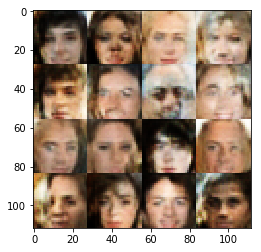

Epoch: 1/1 Discrimator Loss: 1.3525 Generator Loss: 0.8899
Epoch: 1/1 Discrimator Loss: 1.3008 Generator Loss: 0.8256
Epoch: 1/1 Discrimator Loss: 1.1878 Generator Loss: 0.7678
Epoch: 1/1 Discrimator Loss: 0.8838 Generator Loss: 0.9175
Epoch: 1/1 Discrimator Loss: 0.8215 Generator Loss: 0.9661
Epoch: 1/1 Discrimator Loss: 1.1588 Generator Loss: 0.9500
Epoch: 1/1 Discrimator Loss: 1.3578 Generator Loss: 0.6997
Epoch: 1/1 Discrimator Loss: 1.2607 Generator Loss: 0.9516
Epoch: 1/1 Discrimator Loss: 1.2338 Generator Loss: 0.8366
Epoch: 1/1 Discrimator Loss: 1.1939 Generator Loss: 0.8020


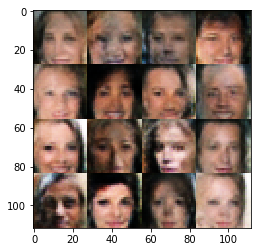

Epoch: 1/1 Discrimator Loss: 1.4396 Generator Loss: 0.7551
Epoch: 1/1 Discrimator Loss: 1.2798 Generator Loss: 0.7536
Epoch: 1/1 Discrimator Loss: 1.1821 Generator Loss: 0.8962
Epoch: 1/1 Discrimator Loss: 1.2157 Generator Loss: 0.9052
Epoch: 1/1 Discrimator Loss: 1.2780 Generator Loss: 0.7638
Epoch: 1/1 Discrimator Loss: 1.1159 Generator Loss: 0.7701
Epoch: 1/1 Discrimator Loss: 1.1986 Generator Loss: 0.8165
Epoch: 1/1 Discrimator Loss: 1.2409 Generator Loss: 0.7734
Epoch: 1/1 Discrimator Loss: 1.2096 Generator Loss: 0.6704
Epoch: 1/1 Discrimator Loss: 1.1888 Generator Loss: 0.8433


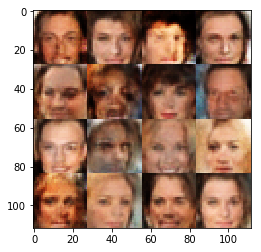

Epoch: 1/1 Discrimator Loss: 1.2590 Generator Loss: 0.8473
Epoch: 1/1 Discrimator Loss: 1.1846 Generator Loss: 0.7810
Epoch: 1/1 Discrimator Loss: 1.4178 Generator Loss: 0.8160
Epoch: 1/1 Discrimator Loss: 1.2091 Generator Loss: 0.8393
Epoch: 1/1 Discrimator Loss: 1.0951 Generator Loss: 0.8342
Epoch: 1/1 Discrimator Loss: 1.1439 Generator Loss: 0.8051
Epoch: 1/1 Discrimator Loss: 1.2318 Generator Loss: 0.7522
Epoch: 1/1 Discrimator Loss: 1.2351 Generator Loss: 0.7812
Epoch: 1/1 Discrimator Loss: 1.2383 Generator Loss: 0.8152
Epoch: 1/1 Discrimator Loss: 1.2058 Generator Loss: 0.8608


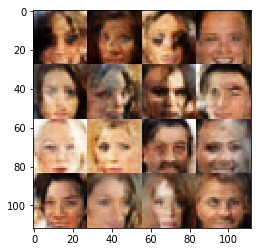

Epoch: 1/1 Discrimator Loss: 1.1979 Generator Loss: 0.7581
Epoch: 1/1 Discrimator Loss: 1.2311 Generator Loss: 0.8032
Epoch: 1/1 Discrimator Loss: 1.1833 Generator Loss: 0.8312
Epoch: 1/1 Discrimator Loss: 1.2892 Generator Loss: 0.7494
Epoch: 1/1 Discrimator Loss: 1.2533 Generator Loss: 0.8561
Epoch: 1/1 Discrimator Loss: 1.1749 Generator Loss: 0.7535
Epoch: 1/1 Discrimator Loss: 1.0847 Generator Loss: 0.7627
Epoch: 1/1 Discrimator Loss: 1.2386 Generator Loss: 0.8074
Epoch: 1/1 Discrimator Loss: 1.1379 Generator Loss: 0.8644
Epoch: 1/1 Discrimator Loss: 1.2187 Generator Loss: 0.8483


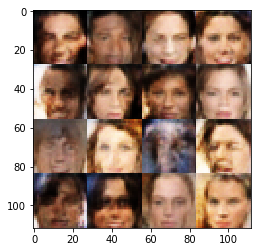

Epoch: 1/1 Discrimator Loss: 1.2034 Generator Loss: 0.8622
Epoch: 1/1 Discrimator Loss: 1.0529 Generator Loss: 0.8324
Epoch: 1/1 Discrimator Loss: 1.0647 Generator Loss: 0.8992
Epoch: 1/1 Discrimator Loss: 1.1996 Generator Loss: 0.8379
Epoch: 1/1 Discrimator Loss: 1.3044 Generator Loss: 0.6491
Epoch: 1/1 Discrimator Loss: 1.1778 Generator Loss: 0.7873
Epoch: 1/1 Discrimator Loss: 1.1246 Generator Loss: 0.7127
Epoch: 1/1 Discrimator Loss: 1.2742 Generator Loss: 0.9032
Epoch: 1/1 Discrimator Loss: 1.2706 Generator Loss: 0.7178
Epoch: 1/1 Discrimator Loss: 1.1472 Generator Loss: 0.7145


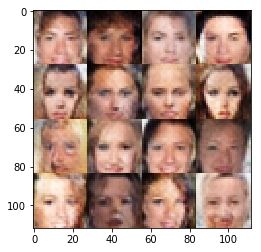

Epoch: 1/1 Discrimator Loss: 1.2641 Generator Loss: 0.8175
Epoch: 1/1 Discrimator Loss: 1.1405 Generator Loss: 0.7414
Epoch: 1/1 Discrimator Loss: 1.3165 Generator Loss: 0.8282
Epoch: 1/1 Discrimator Loss: 1.2850 Generator Loss: 0.8717
Epoch: 1/1 Discrimator Loss: 1.1691 Generator Loss: 0.7691
Epoch: 1/1 Discrimator Loss: 1.0883 Generator Loss: 0.7977
Epoch: 1/1 Discrimator Loss: 1.1537 Generator Loss: 0.8412
Epoch: 1/1 Discrimator Loss: 1.1511 Generator Loss: 0.8266
Epoch: 1/1 Discrimator Loss: 1.2775 Generator Loss: 0.8424
Epoch: 1/1 Discrimator Loss: 1.2243 Generator Loss: 0.7917


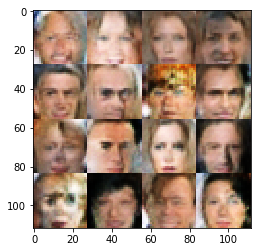

Epoch: 1/1 Discrimator Loss: 1.2639 Generator Loss: 0.8216
Epoch: 1/1 Discrimator Loss: 1.3540 Generator Loss: 0.6203
Epoch: 1/1 Discrimator Loss: 1.2188 Generator Loss: 0.7368
Epoch: 1/1 Discrimator Loss: 1.1392 Generator Loss: 0.8651
Epoch: 1/1 Discrimator Loss: 1.1354 Generator Loss: 0.8078
Epoch: 1/1 Discrimator Loss: 1.2126 Generator Loss: 0.7803
Epoch: 1/1 Discrimator Loss: 1.1574 Generator Loss: 0.7579
Epoch: 1/1 Discrimator Loss: 1.2197 Generator Loss: 0.7064
Epoch: 1/1 Discrimator Loss: 1.2784 Generator Loss: 0.8744
Epoch: 1/1 Discrimator Loss: 1.2178 Generator Loss: 0.6822


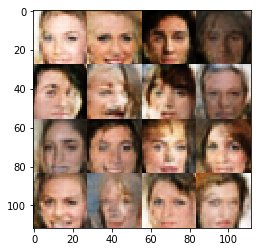

Epoch: 1/1 Discrimator Loss: 1.1929 Generator Loss: 0.8033
Epoch: 1/1 Discrimator Loss: 1.1080 Generator Loss: 0.9069
Epoch: 1/1 Discrimator Loss: 1.1803 Generator Loss: 0.8572
Epoch: 1/1 Discrimator Loss: 1.2162 Generator Loss: 0.7286
Epoch: 1/1 Discrimator Loss: 1.1354 Generator Loss: 0.8896
Epoch: 1/1 Discrimator Loss: 1.1685 Generator Loss: 0.8499
Epoch: 1/1 Discrimator Loss: 1.2122 Generator Loss: 0.7783
Epoch: 1/1 Discrimator Loss: 1.2852 Generator Loss: 0.9351
Epoch: 1/1 Discrimator Loss: 1.2800 Generator Loss: 0.7686
Epoch: 1/1 Discrimator Loss: 1.3452 Generator Loss: 0.7386


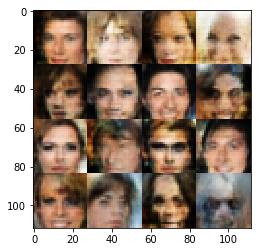

Epoch: 1/1 Discrimator Loss: 1.1857 Generator Loss: 0.7794
Epoch: 1/1 Discrimator Loss: 1.3262 Generator Loss: 0.9551
Epoch: 1/1 Discrimator Loss: 1.1565 Generator Loss: 0.8243
Epoch: 1/1 Discrimator Loss: 1.2490 Generator Loss: 0.8520
Epoch: 1/1 Discrimator Loss: 1.1880 Generator Loss: 0.7775
Epoch: 1/1 Discrimator Loss: 1.2552 Generator Loss: 0.7022
Epoch: 1/1 Discrimator Loss: 1.3870 Generator Loss: 0.6709
Epoch: 1/1 Discrimator Loss: 1.1936 Generator Loss: 0.8847
Epoch: 1/1 Discrimator Loss: 1.1771 Generator Loss: 0.7302
Epoch: 1/1 Discrimator Loss: 1.0297 Generator Loss: 1.0472


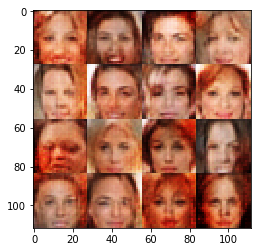

Epoch: 1/1 Discrimator Loss: 1.4202 Generator Loss: 0.6328
Epoch: 1/1 Discrimator Loss: 1.2224 Generator Loss: 0.9287
Epoch: 1/1 Discrimator Loss: 1.3398 Generator Loss: 0.7626
Epoch: 1/1 Discrimator Loss: 1.3326 Generator Loss: 0.6972
Epoch: 1/1 Discrimator Loss: 1.2249 Generator Loss: 0.8044
Epoch: 1/1 Discrimator Loss: 1.1707 Generator Loss: 0.7378
Epoch: 1/1 Discrimator Loss: 1.4401 Generator Loss: 0.6961
Epoch: 1/1 Discrimator Loss: 1.2190 Generator Loss: 0.9147
Epoch: 1/1 Discrimator Loss: 1.0490 Generator Loss: 0.8923
Epoch: 1/1 Discrimator Loss: 1.1711 Generator Loss: 0.8087


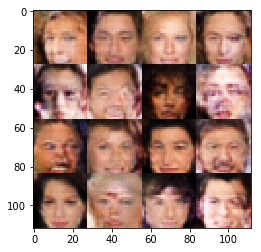

Epoch: 1/1 Discrimator Loss: 1.3568 Generator Loss: 0.9463
Epoch: 1/1 Discrimator Loss: 1.3635 Generator Loss: 0.6894
Epoch: 1/1 Discrimator Loss: 1.1552 Generator Loss: 0.8122
Epoch: 1/1 Discrimator Loss: 1.2035 Generator Loss: 0.8227
Epoch: 1/1 Discrimator Loss: 1.2275 Generator Loss: 0.7535
Epoch: 1/1 Discrimator Loss: 1.3616 Generator Loss: 0.8393
Epoch: 1/1 Discrimator Loss: 1.3243 Generator Loss: 0.7931
Epoch: 1/1 Discrimator Loss: 1.3524 Generator Loss: 0.6929
Epoch: 1/1 Discrimator Loss: 1.2787 Generator Loss: 0.8033
Epoch: 1/1 Discrimator Loss: 1.2110 Generator Loss: 0.8714


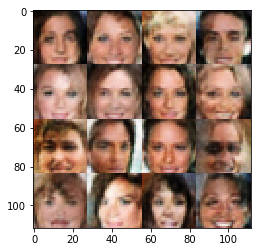

Epoch: 1/1 Discrimator Loss: 1.1836 Generator Loss: 0.8643
Epoch: 1/1 Discrimator Loss: 1.1906 Generator Loss: 0.9174
Epoch: 1/1 Discrimator Loss: 1.1540 Generator Loss: 0.7662
Epoch: 1/1 Discrimator Loss: 1.2670 Generator Loss: 0.8132
Epoch: 1/1 Discrimator Loss: 1.1958 Generator Loss: 0.8569
Epoch: 1/1 Discrimator Loss: 1.1288 Generator Loss: 0.7597
Epoch: 1/1 Discrimator Loss: 1.2889 Generator Loss: 0.8391
Epoch: 1/1 Discrimator Loss: 1.2539 Generator Loss: 0.7943
Epoch: 1/1 Discrimator Loss: 1.1208 Generator Loss: 0.8471
Epoch: 1/1 Discrimator Loss: 1.2885 Generator Loss: 0.8203


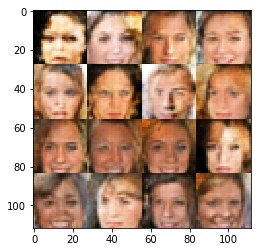

Epoch: 1/1 Discrimator Loss: 1.2286 Generator Loss: 0.7915
Epoch: 1/1 Discrimator Loss: 1.2400 Generator Loss: 0.8667
Epoch: 1/1 Discrimator Loss: 1.0426 Generator Loss: 0.8510
Epoch: 1/1 Discrimator Loss: 1.3048 Generator Loss: 0.8968
Epoch: 1/1 Discrimator Loss: 1.2637 Generator Loss: 0.7615
Epoch: 1/1 Discrimator Loss: 1.3196 Generator Loss: 0.7093
Epoch: 1/1 Discrimator Loss: 1.1645 Generator Loss: 0.7819
Epoch: 1/1 Discrimator Loss: 1.1061 Generator Loss: 0.9379
Epoch: 1/1 Discrimator Loss: 1.4726 Generator Loss: 0.9254
Epoch: 1/1 Discrimator Loss: 1.3680 Generator Loss: 0.7866


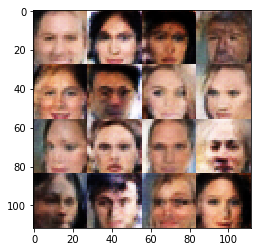

Epoch: 1/1 Discrimator Loss: 1.1012 Generator Loss: 0.9254
Epoch: 1/1 Discrimator Loss: 1.1689 Generator Loss: 0.7392
Epoch: 1/1 Discrimator Loss: 1.2374 Generator Loss: 0.6963


In [90]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.